<a href="https://colab.research.google.com/github/asokraju/marl/blob/master/colab/adversial_cooperative_distributed_marl_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports 

In [1]:
#PYPI modules
import numpy as np
import random
import gym
from gym import spaces

import tensorflow as tf
import matplotlib.pyplot as plt
import argparse
from tensorflow import keras
from tensorflow.keras import Input, Model, Sequential, layers
import datetime
from scipy.io import savemat
import tensorflow_probability as tfp
from collections import deque

In [4]:
t=101
node =2
if (t>100) & (node is not 1):
    print("ad")

ad


#Replay buffer

In [ ]:
class ReplayBuffer(object):

    def __init__(self, buffer_size, random_seed=123):
        """
        The right side of the deque contains the most recent experiences 
        """
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()
        random.seed(random_seed)

    def add(self, s, a, r, t, s2):
        experience = (s, a, r, t, s2)
        if self.count < self.buffer_size: 
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample_batch(self, batch_size):
        batch = []

        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)

        s_batch = np.array([_[0] for _ in batch])
        a_batch = np.array([_[1] for _ in batch])
        r_batch = np.array([_[2] for _ in batch])
        t_batch = np.array([_[3] for _ in batch])
        s2_batch = np.array([_[4] for _ in batch])

        return s_batch, a_batch, r_batch, t_batch, s2_batch

    def clear(self):
        self.buffer.clear()
        self.count = 0


#model

In [ ]:
import numpy as np
import random
import gym
from gym import spaces

random.seed(10)
np.random.seed(10)


class Grid_World(gym.Env):
    """
    Multi agent Grid-World
    Objective of each agent is to reach their desired positions without colliding and following a shortest path
    nrow, ncol: dimensions of the grid world 
    n_agents: number of agents/players
    rew_scaling: if True scales the reward with some values [p1,p2,p3] (s.t. p1+p2+p3 =1 ), 
                 for example for 3 agents, the rewards [r1,r2,r3] will be transformed to
                  [p1*r1, p2*r2, p3*r3]
    """ 
    metadata = {'render.modes': ['console']}

    def __init__(self, nrow = 5, ncol=5, n_agents = 1, rew_scaling = False):
        super(Grid_World, self).__init__()
        self.nrow = nrow
        self.ncol = ncol
        self.n_agents = n_agents
        self.rew_scaling = rew_scaling

        self.total_states = self.nrow * self.ncol
        self.n_actions = 5
        self.actions = {0:'LEFT', 1:'DOWN', 2:'RIGHT', 3:'UP', 4:'STAY'}
        #self.observation_space = spaces.Discrete(self.total_states*n_agents)
        self.observation_space = gym.spaces.MultiDiscrete([self.total_states for _ in range(self.n_agents)])
        self.action_space = gym.spaces.MultiDiscrete([self.n_actions for _ in range(self.n_agents)])

        self._state_map()
        self._get_state()
        self._get_desired()
        self._reward_scaling()

        self.reward, self.done = np.full_like(self.state, 0.0), False

    def _get_state(self):
        self.state = np.array(random.sample(range(self.total_states), self.n_agents))

    def _get_desired(self):
        self.desired_state = np.array([0, 4, 14, 24, 32])#np.array(random.sample(range(self.total_states), self.n_agents) )

    def _set_state(self, state):
        self.state = state

    def _set_desired(self, desired_state):
        self.desired_state = desired_state
    
    def _reward_scaling(self):
        temp = np.random.uniform(low=0, high=1, size=(self.n_agents,))
        self.reward_scaling = temp/temp.sum()

    def _to_s(self, row, col):
        return row*self.ncol + col
    
    def _state_map(self):
        """
        self.state_transformation: is a dict with 
                                    key - (x,y) co-ordinate
                                    vaue - state (0 - self.total_states)
        self.i_state_transformation: is a dict with 
                                    key - state (0 - self.total_states)
                                    vaue - (x,y) co-ordinate                                   
        """
        self.state_transformation={}
        for row in range(self.nrow):
            for col in range(self.ncol):
                self.state_transformation[(row, col)] = self._to_s(row, col)
        self.i_state_transformation={}
        for key, value in self.state_transformation.items():
            self.i_state_transformation[value]=key

    def _dist(self, s1, s2):
        """
        measures the shortest distance between the state s1 and s2
        arguments: s1, s2 are integers
        returns: integer
        """
        x1, y1 = self.i_state_transformation[s1]
        x2, y2 = self.i_state_transformation[s2]
        return abs(x1-x2)+abs(y1-y2)

    def _inc(self, row, col, a):
        """
        at (row,col) coordinate, taking the action from (0,1,2,3)
        we arrive at (row, col) coordinate
        
        arguments: row, col, a are integers
        a:  0 - LEFT
            1 - DOWN
            2 - RIGHT
            3 - UP
        returns: (row, col) tuple of integers
        """
        if a == 0:
            col = max(col - 1, 0)
        elif a == 1:
            row = min(row + 1, self.nrow - 1)
        elif a == 2:
            col = min(col + 1, self.ncol - 1)
        elif a == 3:
            row = max(row - 1, 0)
        return (row, col)
    
    def reset(self):
        """
        resets the environment
        1 - resets the state and its desired values to some random values
        2- returns the current state numpy array of dim (self.n_agents, )
        """
        self._get_state()
        #self._get_desired()
        return self.state

    def step(self, a):
        """
        --returns the new state, reward, terminal states after taking action a

        -arguments
        a: represent the actions of all agents, a numpy array of shape (self.n_agents, )
        -returns
        self.state: numpy array (self.n_agents, )
        self.reward: numpy array (self.n_agents, )
        done: True (if all agents reached their desired positions) or False (otherwise)
        """
        temp_s = []
        rew =[]
        d = []
        for s,a, s_d in zip(self.state, a, self.desired_state):
            x, y = self.i_state_transformation[s]
            new_x, new_y = self._inc(x, y, a)
            new_s = self.state_transformation[(new_x, new_y)]
            temp_s.append(new_s)
            rew.append(-self._dist(s,s_d))

        for i, s in enumerate(self.state):
            sub_s = np.delete(self.state, [i])
            if s in sub_s:
                rew[i] = rew[i] - 1#(self.ncol+self.nrow)/2
        
        self.state = np.array(temp_s)
        if self.rew_scaling:
            self.reward = np.array(rew)*self.reward_scaling
        else:
            self.reward = np.array(rew, dtype=float)
        self.done = np.array_equal(self.state, self.desired_state)

        return self.state, self.reward, self.done, {}
    
    def get_node(self, node_index, complete_state = True):
        """
        This can be used to control information leak in MARL
        using get_node we get the reward of the specified node (only)
        If complete_state is False, then we can not observe the states of other agents
        always use get_node after using the step method
        -arguments
        node_index: integer in (0, self.n_agents)
        complete_state: bool
        """
        if complete_state:
            return self.state, self.reward[node_index], self.done, {}
        else:
            return self.state[node_index], self.reward[node_index], self.done, {}

    def close(self):
        pass
# #example
env = Grid_World(6,6,5)
# print(env.observation_space.shape[0])
# print(env.action_space.shape[0])
# state = env.reset()


# print("inital state")
# print([env.i_state_transformation[s_a] for s_a in state])

# s_1, r_1, t_1, _ = env.get_node(0)
# print("initial reward, states of node 0:", s_1, r_1, t_1)

# print("going left")
# state,r,t,_ =env.step([0 for _ in range(env.n_agents)])
# print([env.i_state_transformation[s_a] for s_a in state])

# print("going Right")
# state,r,t,_ =env.step([2 for _ in range(env.n_agents)])
# print([env.i_state_transformation[s_a] for s_a in state])

# print("going down")
# state,r,t,_ =env.step([1 for _ in range(env.n_agents)])
# print([env.i_state_transformation[s_a] for s_a in state])

# print("going up")
# state,r,t,_ =env.step([3 for _ in range(env.n_agents)])
# print([env.i_state_transformation[s_a] for s_a in state])

# print("Staying in the same place")
# state,r,t,_ =env.step([4 for _ in range(env.n_agents)])
# print([env.i_state_transformation[s_a] for s_a in state])

#Actor

In [ ]:
num_actions = 5
actor_1 = keras.Sequential([
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(num_actions, activation='softmax')
])
actor_1.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam())

actor_2 = keras.Sequential([
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(num_actions, activation='softmax')
])
actor_2.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam())

actor_3 = keras.Sequential([
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(num_actions, activation='softmax')
])
actor_3.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam())

actor_4 = keras.Sequential([
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(num_actions, activation='softmax')
])
actor_4.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam())

actor_5 = keras.Sequential([
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(num_actions, activation='softmax')
])
actor_5.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam())

actors = [actor_1, actor_2, actor_3, actor_4, actor_5]

#Critic

In [ ]:
critic_output = 1

critic_1 = keras.Sequential([
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(critic_output)
])
critic_1.compile(loss='mse',optimizer=keras.optimizers.Adam())

critic_2 = keras.Sequential([
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(critic_output)
])
critic_2.compile(loss='mse',optimizer=keras.optimizers.Adam())

critic_3 = keras.Sequential([
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(critic_output)
])
critic_3.compile(loss='mse',optimizer=keras.optimizers.Adam())

critic_4 = keras.Sequential([
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(critic_output)
])
critic_4.compile(loss='mse',optimizer=keras.optimizers.Adam())

critic_5 = keras.Sequential([
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(critic_output)
])
critic_5.compile(loss='mse',optimizer=keras.optimizers.Adam())

critics = [critic_1, critic_2, critic_3, critic_4, critic_5]

In [ ]:
rew_output = 1

rew_1 = keras.Sequential([
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(rew_output)
])
rew_1.compile(loss='mse',optimizer=keras.optimizers.Adam())

rew_2 = keras.Sequential([
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(rew_output)
])
rew_2.compile(loss='mse',optimizer=keras.optimizers.Adam())

rew_3 = keras.Sequential([
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(rew_output)
])
rew_3.compile(loss='mse',optimizer=keras.optimizers.Adam())

rew_4 = keras.Sequential([
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(rew_output)
])
rew_4.compile(loss='mse',optimizer=keras.optimizers.Adam())

rew_5 = keras.Sequential([
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal()),
    keras.layers.Dense(rew_output)
])
rew_5.compile(loss='mse',optimizer=keras.optimizers.Adam())

rew_approx = [rew_1, rew_2, rew_3, rew_4, rew_5]

#Alternatively


In [ ]:
# class Actor(tf.keras.Model):
#     """
#     creates a two layer nn with a soft max output layer for actor.
#     we use 'categorical_crossentropy' as the loss function and Adam optimzer
#     Arguments:
#     num_actions - (int) 
#     lr - (float)
#     """
#     def __init__(self, num_actions = 5):
#         super(Actor, self).__init__()
#         self.dense_1 = keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal())
#         self.dense_2 = keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal())
#         self.output_layer = keras.layers.Dense(num_actions, activation='softmax')

#     def call(self, inputs):
#         x = self.dense_1(inputs)
#         x = self.dense_2(x)
#         return self.output_layer(x)




# class Critic(tf.keras.Model):
#     """
#     creates a two layer nn with a soft max output layer for critic.
#     """
#     def __init__(self):
#         super(Critic, self).__init__()
#         self.dense_1 = keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal())
#         self.dense_2 = keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal())
#         self.output_layer = keras.layers.Dense(1)
#         #self.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam())


#     def call(self, inputs):
#         x = self.dense_1(inputs)
#         x = self.dense_2(x)
#         return self.output_layer(x)

# critics = [Critic() for _ in range(env.n_agents)]

# huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
# for critic in critics:
#     critic.compile(loss = huber_loss, optimizer = keras.optimizers.Adam(learning_rate=args['critic_lr']))

# actors = [Actor(num_actions = env.n_actions) for _ in range(env.n_agents)]
# for actor in actors:
#     actor.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=args['actor_lr']))

#Train

In [ ]:
def discount_reward(rewards, GAMMA=0.95):
    reward_sum = 0
    discounted_rewards = []
    for reward in rewards[::-1]:  # reverse buffer r
        reward_sum = reward + GAMMA * reward_sum
        discounted_rewards.append(reward_sum)
    discounted_rewards.reverse()
    discounted_rewards = np.array(discounted_rewards)
    len = discounted_rewards.shape[0]
    return np.array(discounted_rewards).reshape((len, 1))

def get_action(actor_model, state, eps=0.04):
    p = actor_model.predict(np.reshape(state, (1,-1)))#.numpy()
    n_actions = np.shape(p)[1]
    action_from_policy = np.random.choice(n_actions, p = p[0])
    random_action=np.random.choice(5)
    #np.random.choice([action_from_policy,random_action], p = [1-eps,eps])
    return np.random.choice([action_from_policy,random_action], p = [1-eps,eps])

def train_multi_agent(env, args, actors, critics, reward_result):
    
    # Needs 'ReplayBuffer' class
    writer = tf.summary.create_file_writer(logdir = args['summary_dir'])

    nodes = env.n_agents
    des=np.array([0, 4, 14, 24, 32])
    adv_des=np.array([0, 35, 35, 35, 35])
    paths = list()

    x = np.arange(env.total_states)
    if args['scaling']:
        mean, var = x.mean(), x.var()
    else:
        mean, var = 0, 1

    _eps = .5
    for t in range(args['max_episodes']):
        #resetting the environments
        env.reset()

        #conditions on exploration
        if t<10:
            eps = _eps/(t+1)
        else:
            eps = 0.04

        
        ep_reward = 0

        #initializing the lists
        obs, obs_scaled, actions, rewards = [[] for _ in range(nodes)], [[] for _ in range(nodes)], [[] for _ in range(nodes)], [[] for _ in range(nodes)]
        rewards_mean = [[] for _ in range(nodes)]
        #rewards_predicted = [[] for _ in range(nodes)]
        done = False
        #running the episode
        j= 0
        #we first save all the samples in the replay buffer
        for node in range(nodes):
            s, r, done, _ = env.get_node(node)
            s_scaled = (s-mean)/var
            obs[node].append(s.tolist())
            obs_scaled[node].append(s_scaled.tolist())

        average_critic_weights = [[] for _ in range(nodes)]
        if done:
            print(t,j)
        while not done:
            for node in range(nodes):
                if args['scaling']:
                    a = get_action(actors[node], obs_scaled[node][-1], eps = eps)
                else:
                    a = get_action(actors[node], obs[node][-1], eps = eps)
                actions[node].append(a)    
        
            _, new_reward, done, _ = env.step([actions[node][-1] for node in range(nodes)])
            if done:
                print("done={}".formaat(done))
            for node in range(nodes):
                s, r, done, _ = env.get_node(node)
                obs[node].append(s.tolist())
                if node==0:
                    temp = 0
                    for s1, s2 in zip(adv_des,s):
                        x1, y1 = env.i_state_transformation[s1]
                        x2, y2 = env.i_state_transformation[s2]
                        temp = temp + abs(x1-x2)+abs(y1-y2)
                    r =  -3*temp
                s = (s-mean)/var
                obs_scaled[node].append(s.tolist())
                rewards[node].append(r)
                rewards_mean[node].append(new_reward.mean())
            ep_reward = ep_reward + new_reward
            j= j+1
            if done | (j==args['max_episode_len']):
                act_loss, crit_loss, rew_loss = [], [], []
                #training the reward network
                for node in range(nodes):
                    states = np.vstack(obs_scaled[node][:-1])

                    for _ in range(100):
                        r_loss = rew_approx[node].train_on_batch(states, np.reshape(rewards[node], (-1,1)))
                    rew_loss.append(r_loss)

                #Consensus update on the reward network
                for i in range(len(rew_approx[node].trainable_variables)):
                    temp = 0
                    for node in range(nodes):
                        temp = temp + rew_approx[node].trainable_variables[i]
                    for node in range(nodes):
                        rew_approx[node].trainable_variables[i].assign(temp/env.n_agents)

                #training the Actor and Critic networks
                for node in range(nodes):
                    states = np.vstack(obs_scaled[node][:-1])
                    final_state = np.vstack(obs_scaled[node][-1])
                    predicted_rewards = rew_approx[node].predict(states)
                    if node==0:
                        returns = discount_reward(rewards[node], GAMMA=args['gamma'])
                    else:
                        returns = discount_reward(predicted_rewards, GAMMA=args['gamma'])
                    #returns = discount_reward(rewards_mean[node], GAMMA=args['gamma'])
                    returns -= np.mean(returns)
                    returns /= np.std(returns)
                    
                    targets_actions = np.array([[1 if a==i else 0 for i in range(env.n_actions)]  for j, a in enumerate(actions[node])])

                    V_s0 = critics[node].predict(states)
                    V_s1 = critics[node].predict(np.reshape(final_state,(1, len(final_state))))

                    fin_discount = np.array([args['gamma'] ** (i+1) for i in range(j)][::-1])*V_s1
                    td = returns + fin_discount.reshape((j,1)) - V_s0

                    
                    for _ in range(100-np.min([np.int(t/1), 99])):
                        c_loss = critics[node].train_on_batch(states, returns+fin_discount.reshape((j,1)))
                    
                    for _ in range(10-np.min([np.int(t/10),9])):
                        a_loss = actors[node].train_on_batch(states, targets_actions, sample_weight=td)
                    act_loss.append(a_loss)
                    crit_loss.append(c_loss)
                
                #Consensus update on the critic networks
                for i in range(len(critics[node].trainable_variables)):
                    temp = 0
                    for node in range(nodes):
                        temp = temp + critics[node].trainable_variables[i]
                    for node in range(nodes):
                        critics[node].trainable_variables[i].assign(temp/env.n_agents)


                with writer.as_default():
                    tf.summary.scalar("actor loss", np.mean(act_loss), step = t)
                    tf.summary.scalar("critic loss", np.mean(crit_loss), step = t)
                    tf.summary.scalar("critic loss", np.mean(rew_loss), step = t)
                    writer.flush()
                print('| Reward: {} | Episode: {} | actor loss: {} |critic loss: {} | reward loss: {} | done: {}'.format(ep_reward, t, np.mean(act_loss), np.mean(crit_loss),np.mean(rew_loss), done))
                fig, ax = plt.subplots(nrows=1, ncols=5, figsize = (24,4))
                for i in range(5):
                    ax[i].plot(range(j), rewards[i])
                plt.show()
                reward_result[t] = ep_reward.sum()

                path = {
                    "Observation":obs, 
                    "Action":actions,#np.concatenate(actions), 
                    "Reward":rewards#np.asarray(rewards)
                    }
                paths.append(path)
                break
                done = False
    return [paths, reward_result] 


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


| Reward: [-5648. -4204. -3771. -4426. -3860.] | Episode: 0 | actor loss: 2.530793380737305 |critic loss: 0.7001214385032654 | reward loss: 377.3526268005371 | done: False


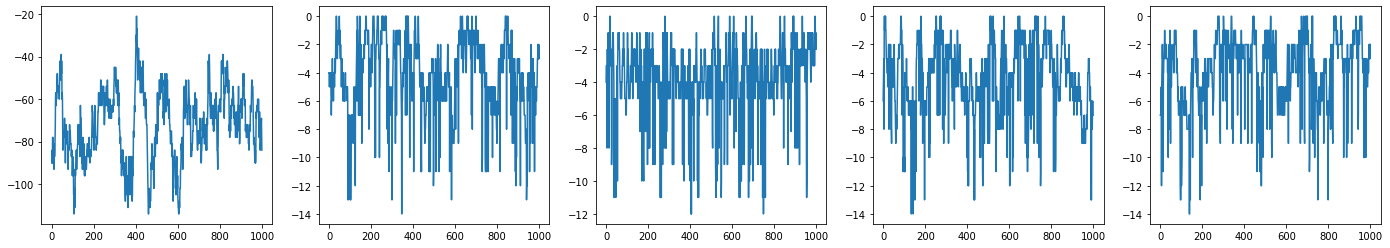

| Reward: [-5320. -4469. -3789. -5110. -3066.] | Episode: 1 | actor loss: -0.08540730327367782 |critic loss: 0.7833233594894409 | reward loss: 482.7533480644226 | done: False


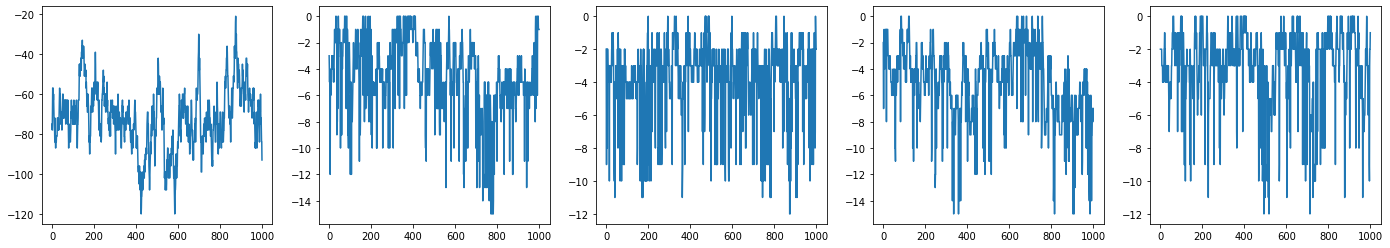

| Reward: [-4697. -4798. -3336. -5559. -3433.] | Episode: 2 | actor loss: -0.01126770516857505 |critic loss: 0.6720806717872619 | reward loss: 462.07914247512815 | done: False


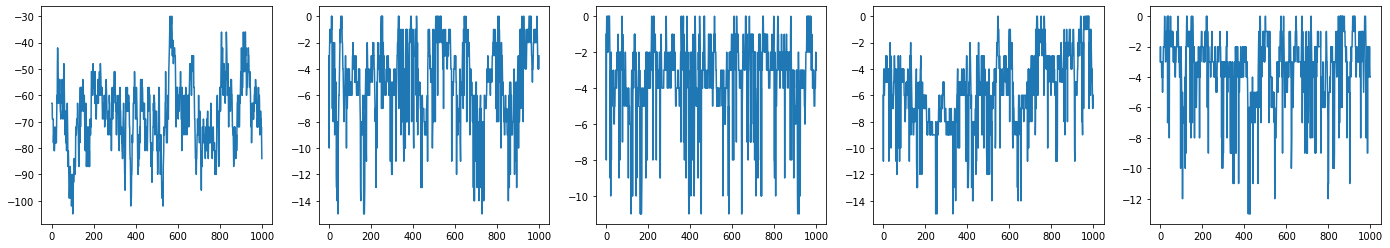

| Reward: [-4780. -4536. -3564. -4969. -3478.] | Episode: 3 | actor loss: -0.008331602904945612 |critic loss: 0.6496298313140869 | reward loss: 473.2546175003052 | done: False


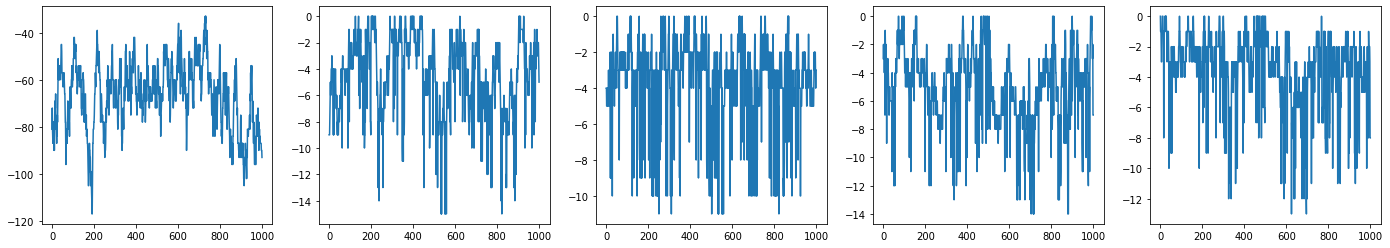

| Reward: [-5224. -4064. -3420. -5360. -3464.] | Episode: 4 | actor loss: -0.14553990066051484 |critic loss: 0.8260005474090576 | reward loss: 513.7983678817749 | done: False


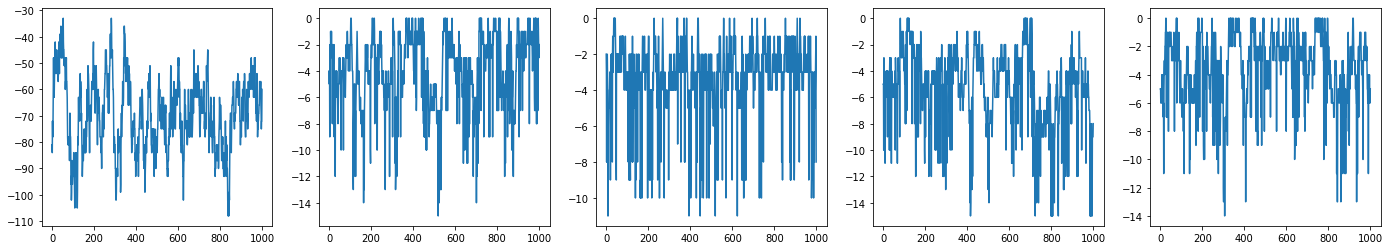

| Reward: [-4376. -4670. -3784. -5278. -3270.] | Episode: 5 | actor loss: 0.03968980610370636 |critic loss: 0.653124725818634 | reward loss: 439.8160568237305 | done: False


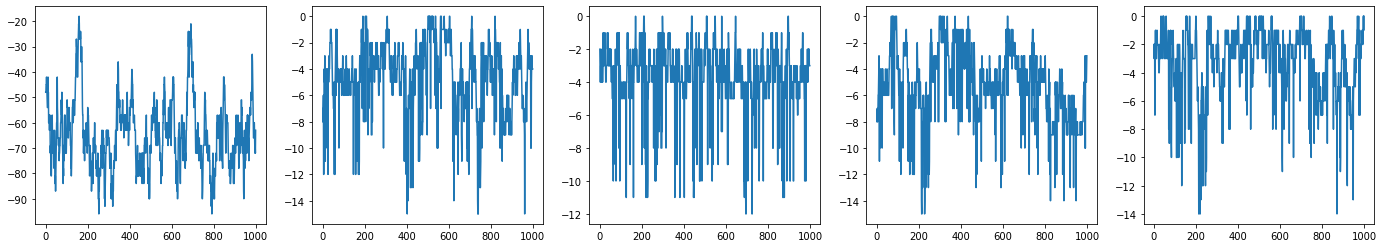

| Reward: [-3942. -3422. -3462. -4727. -2659.] | Episode: 6 | actor loss: -0.2830990791320801 |critic loss: 0.8208104610443115 | reward loss: 473.92711982727053 | done: False


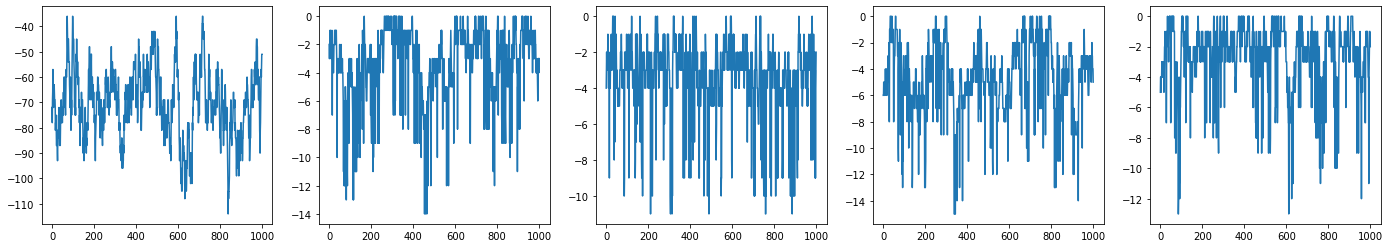

| Reward: [-3465. -4195. -3784. -4432. -2774.] | Episode: 7 | actor loss: -0.1162270575761795 |critic loss: 0.8540412306785583 | reward loss: 435.7002461433411 | done: False


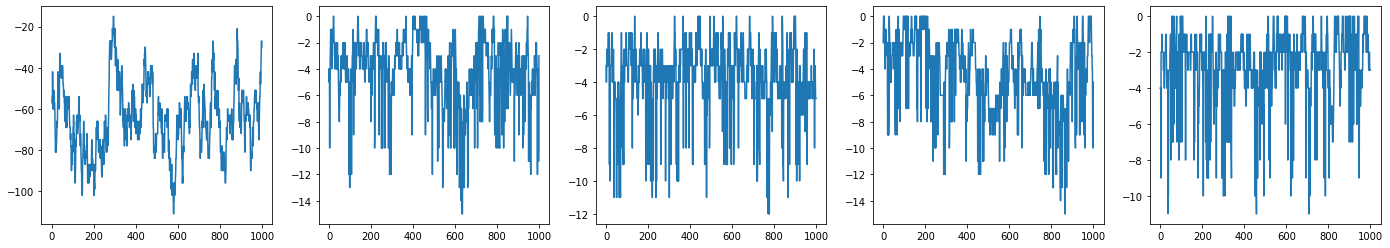

| Reward: [-3820. -2988. -3521. -4746. -2985.] | Episode: 8 | actor loss: 0.03306628353893757 |critic loss: 0.5499483466148376 | reward loss: 452.9558753967285 | done: False


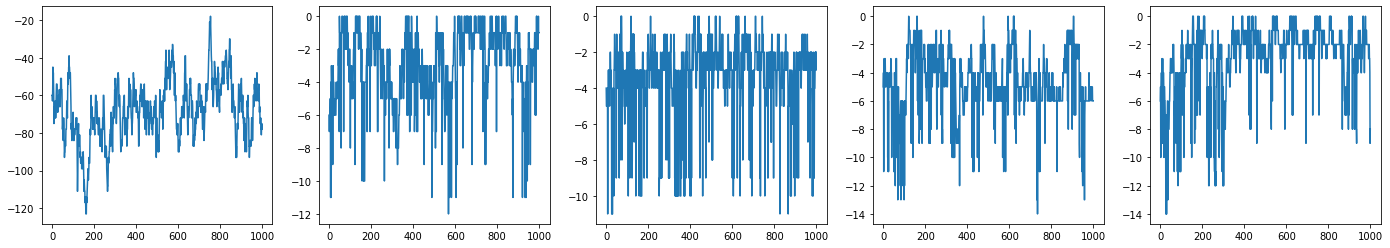

| Reward: [-3199. -3686. -3478. -5180. -3070.] | Episode: 9 | actor loss: -0.17969194650650025 |critic loss: 0.644904088973999 | reward loss: 369.5455590248108 | done: False


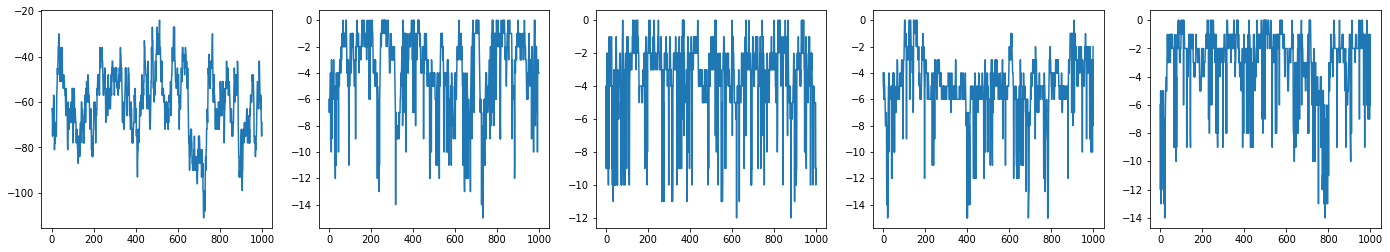

| Reward: [-2498. -3799. -3345. -5607. -2496.] | Episode: 10 | actor loss: -0.2044803112745285 |critic loss: 0.820608651638031 | reward loss: 318.388214635849 | done: False


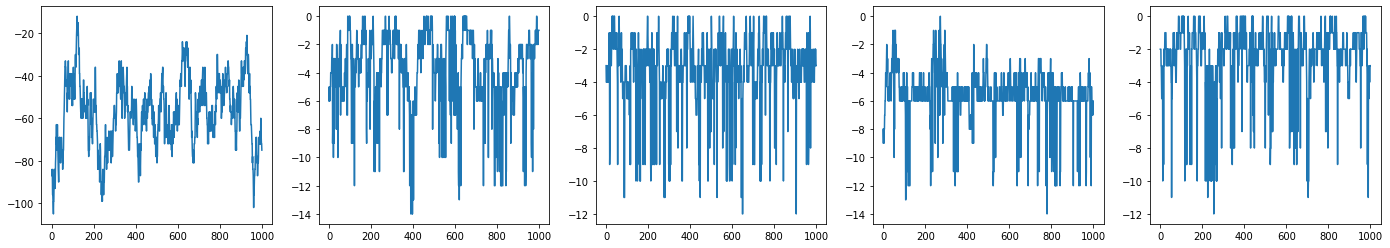

| Reward: [-2198. -2974. -3813. -5088. -2333.] | Episode: 11 | actor loss: -0.16313551962375641 |critic loss: 0.8696463704109192 | reward loss: 274.6791656494141 | done: False


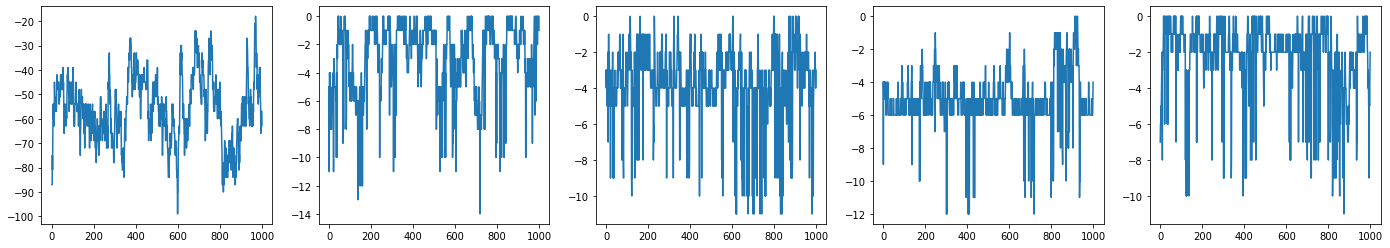

| Reward: [-2593. -2894. -3796. -5006. -2132.] | Episode: 12 | actor loss: -0.08507606238126755 |critic loss: 0.9214199900627136 | reward loss: 261.64367547035215 | done: False


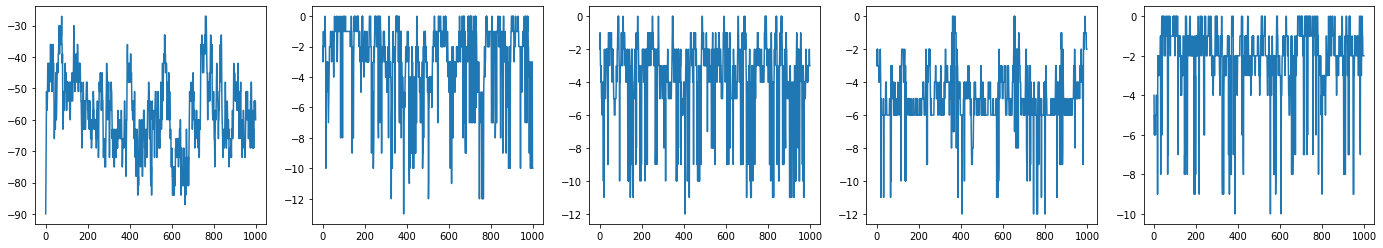

| Reward: [-1923. -2926. -3874. -5083. -2606.] | Episode: 13 | actor loss: 0.041318130865693095 |critic loss: 0.9110687494277954 | reward loss: 231.58170289993285 | done: False


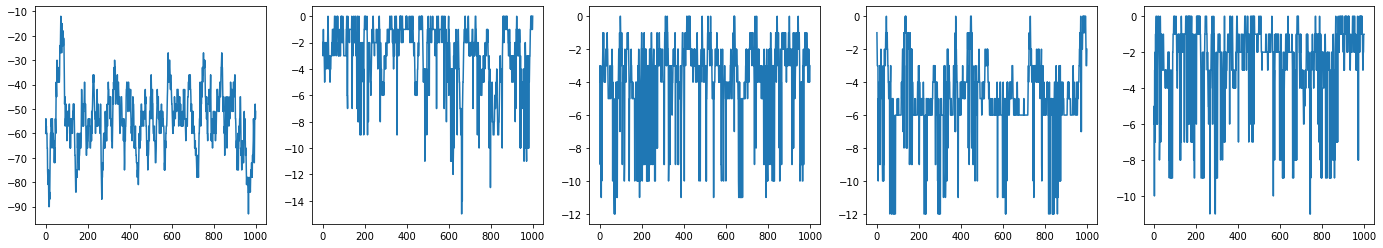

| Reward: [-2196. -3215. -3569. -4664. -2728.] | Episode: 14 | actor loss: -0.01957291583530605 |critic loss: 0.945294713973999 | reward loss: 278.28395042419436 | done: False


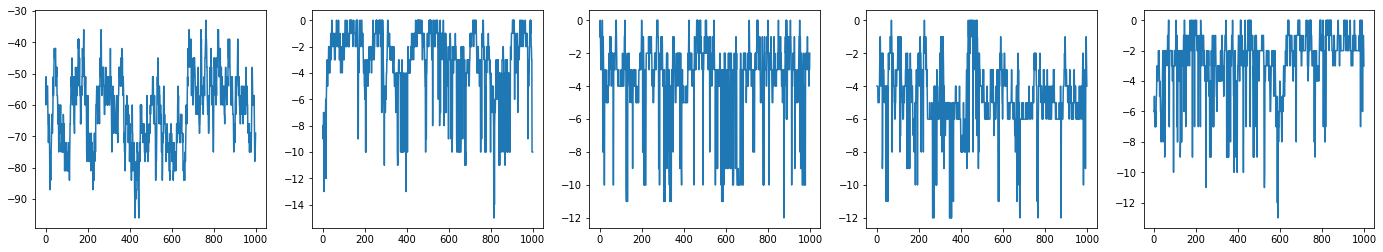

| Reward: [-1785. -3439. -3397. -4618. -2368.] | Episode: 15 | actor loss: -0.16992325186729432 |critic loss: 0.8979440689086914 | reward loss: 235.89727149009704 | done: False


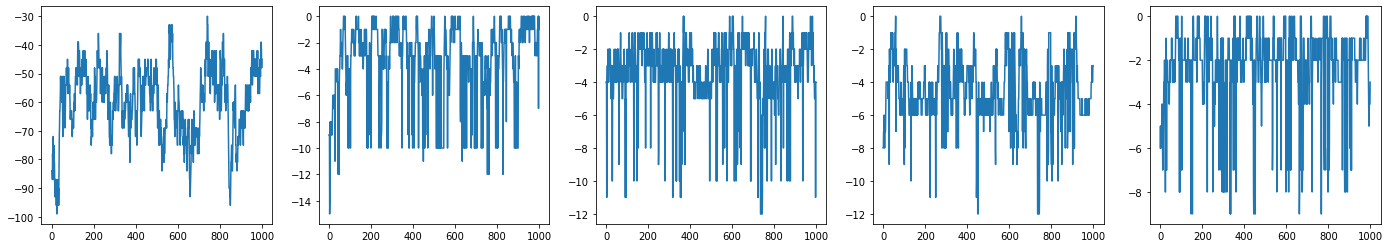

| Reward: [-1782. -2839. -3522. -4308. -2463.] | Episode: 16 | actor loss: -0.05211430415511131 |critic loss: 0.7484581470489502 | reward loss: 237.61123180389404 | done: False


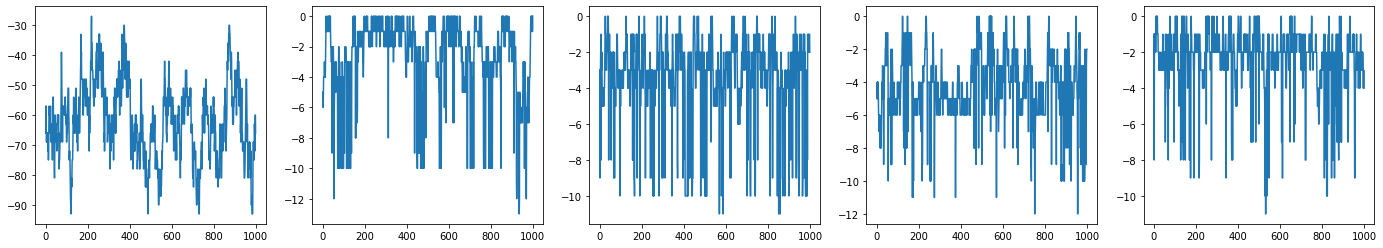

| Reward: [-1917. -3869. -3542. -3806. -2531.] | Episode: 17 | actor loss: -0.026570600271224976 |critic loss: 0.9883891224861145 | reward loss: 215.8621967315674 | done: False


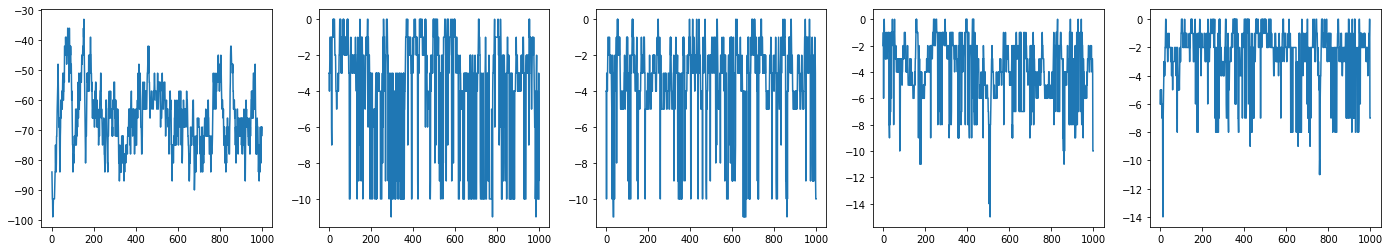

| Reward: [-1964. -4636. -3251. -3259. -2611.] | Episode: 18 | actor loss: 0.03049461226910353 |critic loss: 0.921759569644928 | reward loss: 217.2037034034729 | done: False


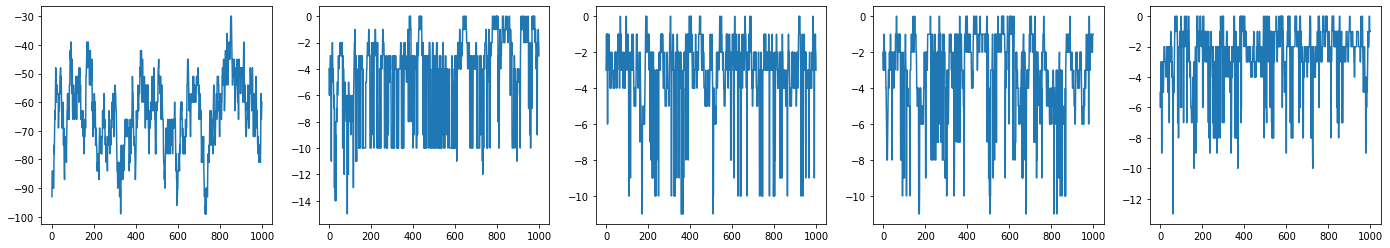

| Reward: [-2526. -5613. -3488. -2999. -2716.] | Episode: 19 | actor loss: -0.12763672918081284 |critic loss: 0.9553268671035766 | reward loss: 216.46799449920655 | done: False


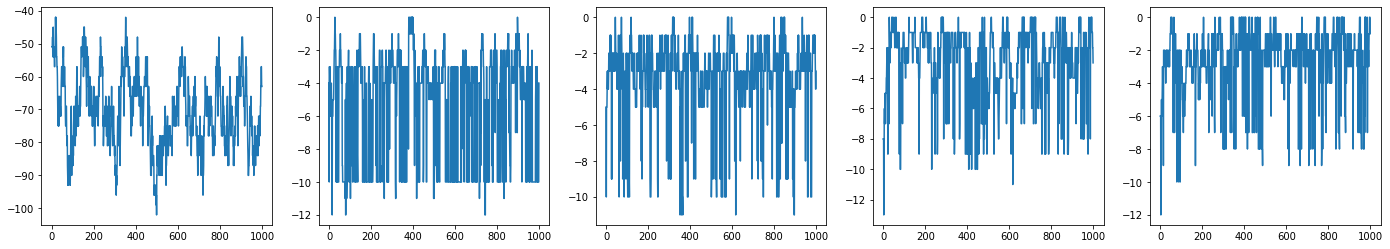

| Reward: [-2845. -5496. -3781. -2804. -2806.] | Episode: 20 | actor loss: -0.015182869322597981 |critic loss: 0.9592477917671204 | reward loss: 189.99332089424132 | done: False


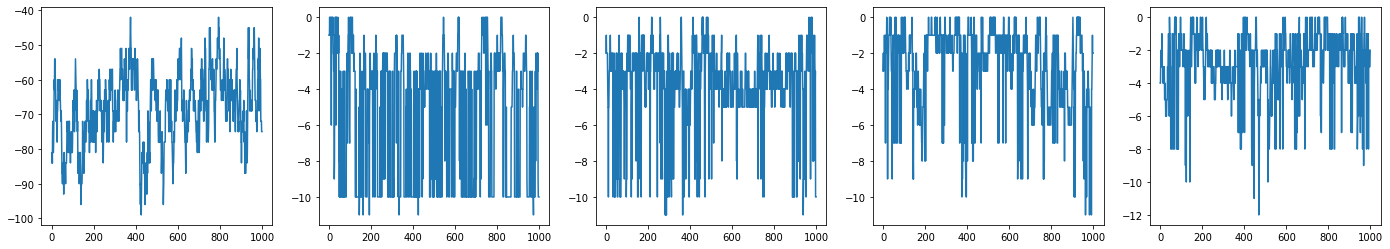

| Reward: [-2574. -5031. -3089. -3087. -2584.] | Episode: 21 | actor loss: -0.010659877763828263 |critic loss: 0.9807576537132263 | reward loss: 210.56448798179628 | done: False


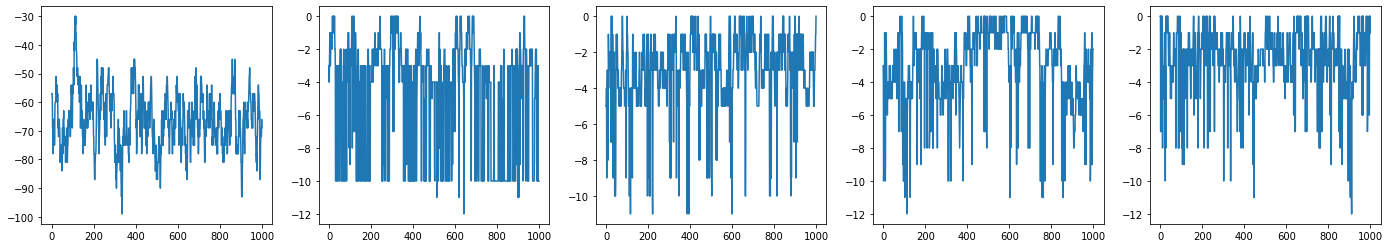

| Reward: [-2678. -5413. -3156. -2763. -2438.] | Episode: 22 | actor loss: -0.038227703794837 |critic loss: 0.9753466486930847 | reward loss: 229.0359486579895 | done: False


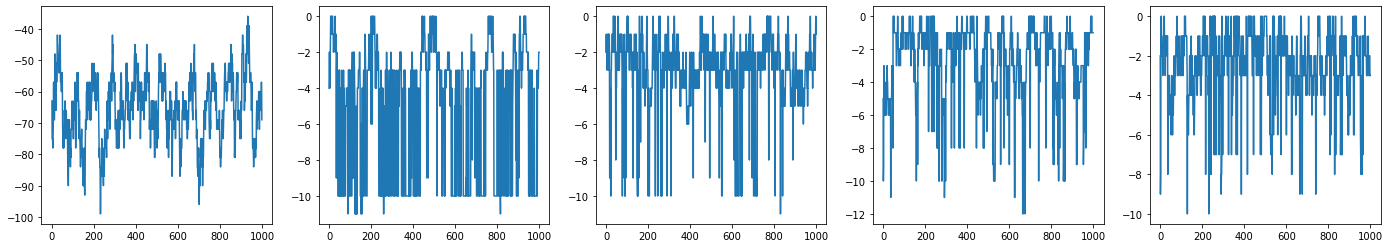

| Reward: [-2532. -4640. -3380. -2238. -2724.] | Episode: 23 | actor loss: 0.03588997796177864 |critic loss: 0.9353975296020508 | reward loss: 267.49406423568723 | done: False


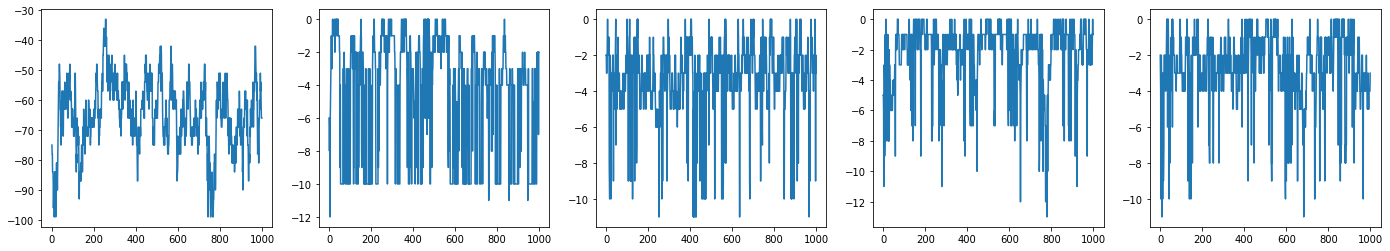

| Reward: [-2662. -5374. -3688. -2064. -2875.] | Episode: 24 | actor loss: -0.21549868285655976 |critic loss: 0.9893449187278748 | reward loss: 253.75326805114747 | done: False


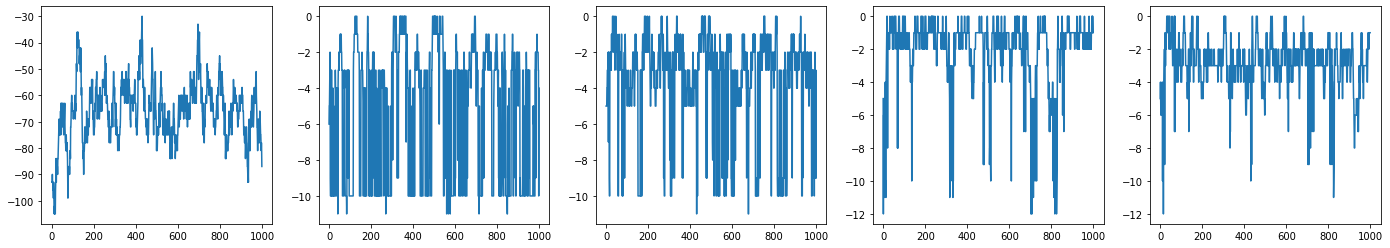

| Reward: [-2392. -4886. -3613. -2004. -2759.] | Episode: 25 | actor loss: -0.05208451673388481 |critic loss: 0.9630195021629333 | reward loss: 212.88721714019775 | done: False


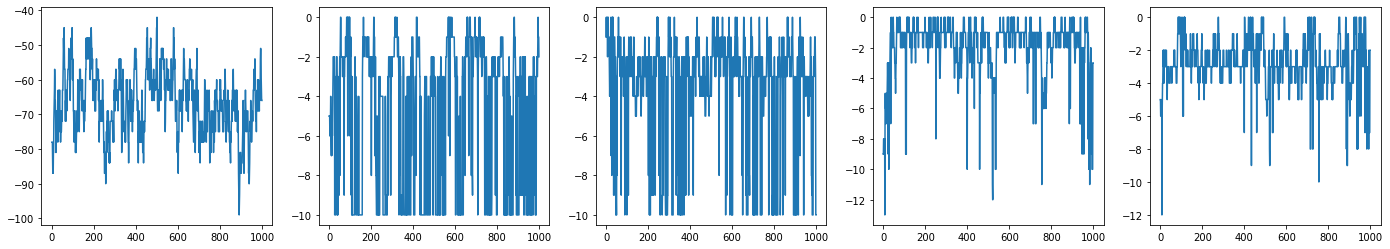

| Reward: [-2103. -4450. -3201. -2202. -2658.] | Episode: 26 | actor loss: -0.04457924440503121 |critic loss: 0.936524772644043 | reward loss: 227.79050765037536 | done: False


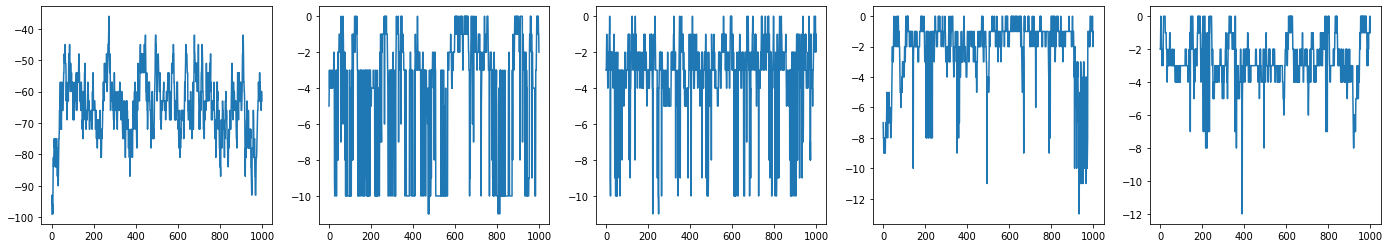

| Reward: [-2142. -4205. -3686. -1636. -2523.] | Episode: 27 | actor loss: -0.09840912222862244 |critic loss: 1.0127583742141724 | reward loss: 236.80648202896117 | done: False


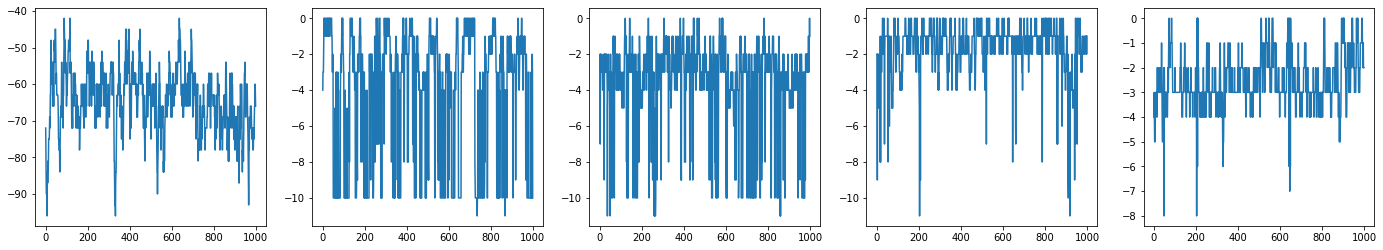

| Reward: [-2538. -5349. -3589. -1891. -2612.] | Episode: 28 | actor loss: -0.029950308427214623 |critic loss: 0.9577333450317382 | reward loss: 237.34619212150574 | done: False


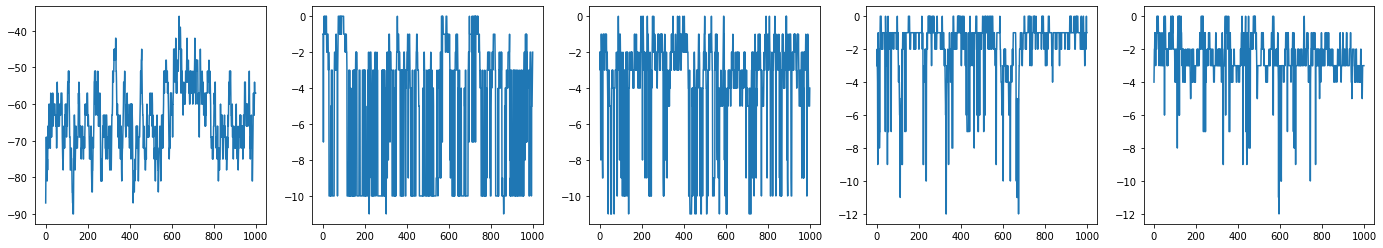

| Reward: [-2139. -4651. -3301. -1393. -2510.] | Episode: 29 | actor loss: 0.013656540215015412 |critic loss: 0.9640331268310547 | reward loss: 197.7799522161484 | done: False


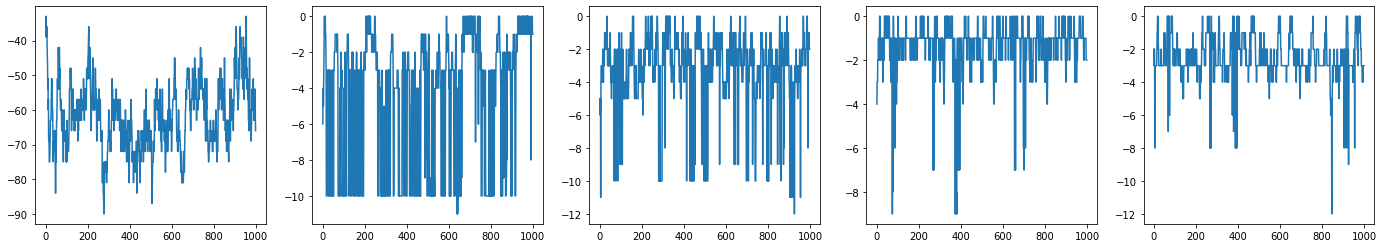

| Reward: [-2107. -4150. -3321. -1623. -2553.] | Episode: 30 | actor loss: 0.037092434242367744 |critic loss: 0.8639498949050903 | reward loss: 246.43157677650453 | done: False


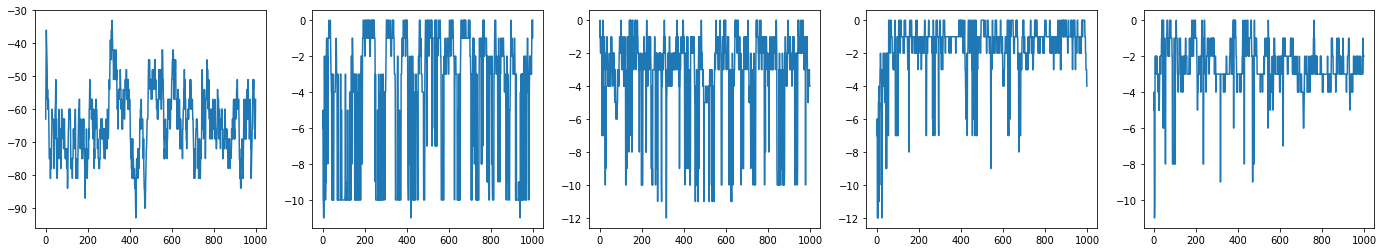

| Reward: [ -975. -2536. -3261. -1844. -2661.] | Episode: 31 | actor loss: -0.24631908535957336 |critic loss: 0.9287885665893555 | reward loss: 214.26702678203583 | done: False


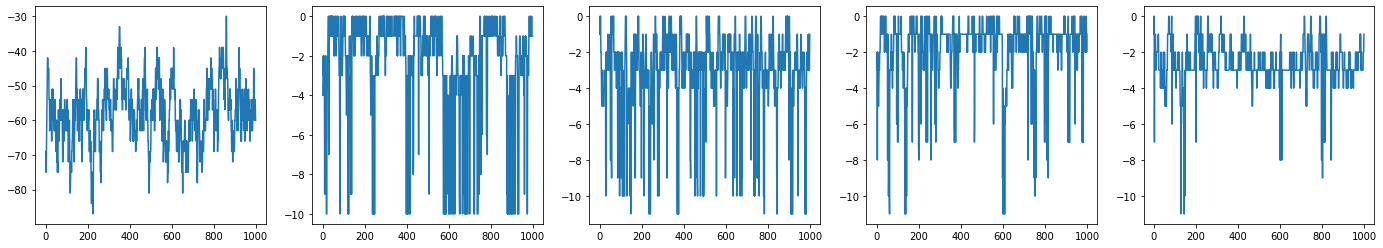

| Reward: [ -572. -1410. -2991. -1391. -2834.] | Episode: 32 | actor loss: -0.04852214977145195 |critic loss: 0.8959768295288086 | reward loss: 213.25190477371217 | done: False


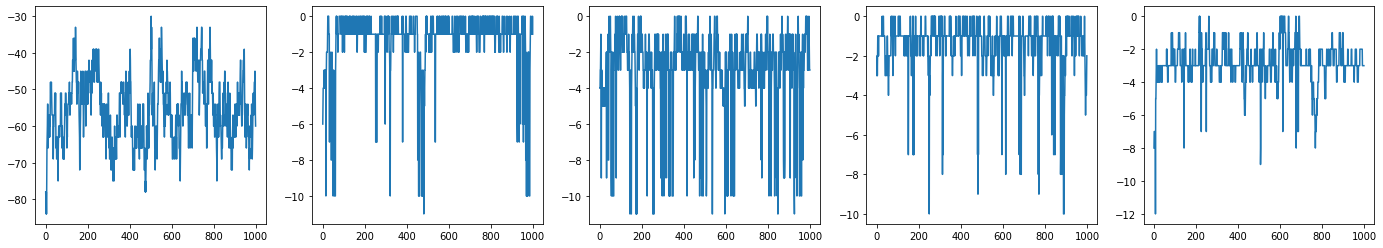

| Reward: [ -584. -1346. -3091. -1771. -2295.] | Episode: 33 | actor loss: -0.12443820983171464 |critic loss: 0.9653587818145752 | reward loss: 249.82017855644227 | done: False


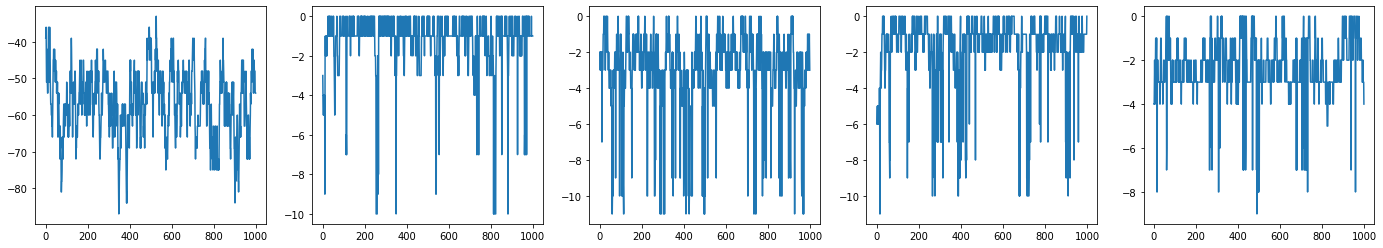

| Reward: [ -320. -1014. -3020. -1749. -2567.] | Episode: 34 | actor loss: -0.027542772330343725 |critic loss: 0.9783152580261231 | reward loss: 207.40986959934236 | done: False


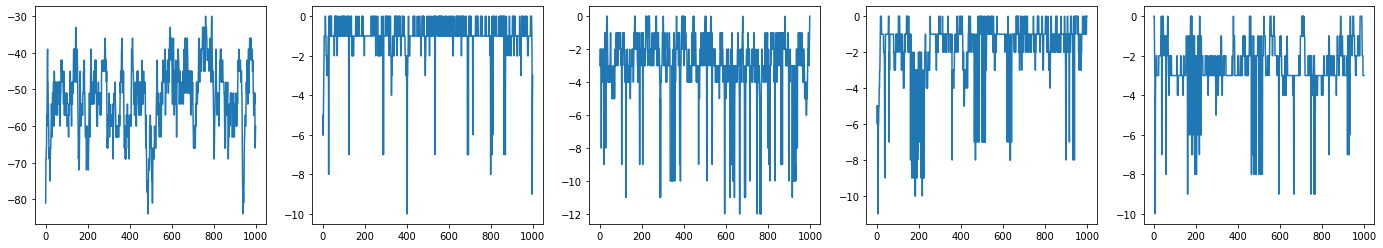

| Reward: [ -708. -1244. -3229. -1686. -2492.] | Episode: 35 | actor loss: 0.0359517018776387 |critic loss: 0.6728963375091552 | reward loss: 247.65303258895875 | done: False


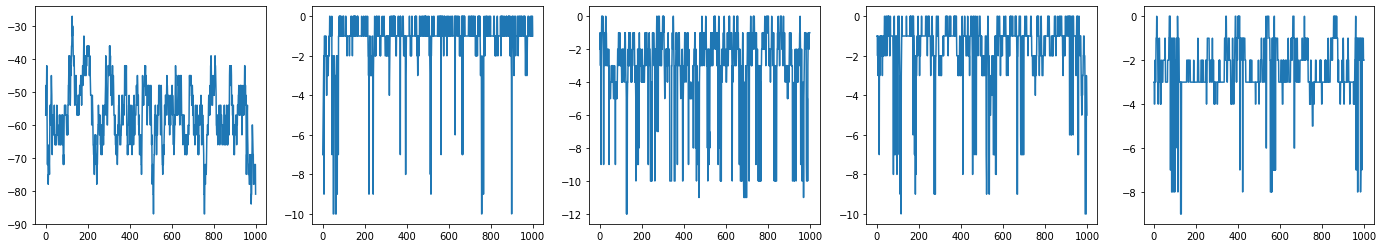

| Reward: [ -604. -1090. -3398. -2148. -2421.] | Episode: 36 | actor loss: -0.25919983088970183 |critic loss: 0.9075181722640991 | reward loss: 221.86690919399263 | done: False


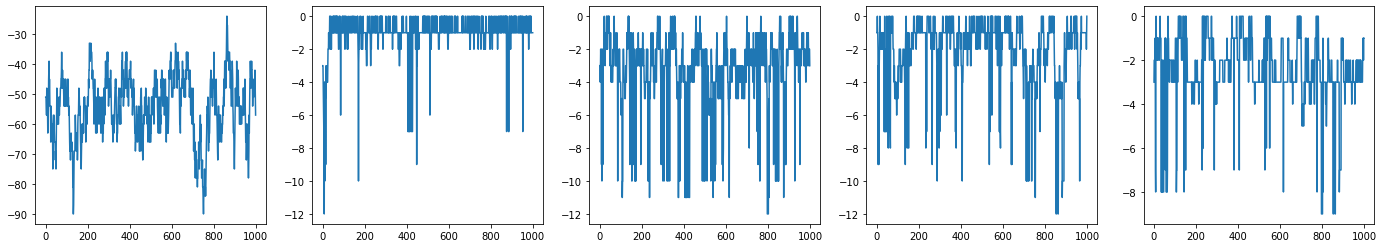

| Reward: [ -360. -1283. -3360. -1783. -2854.] | Episode: 37 | actor loss: -0.13167487233877181 |critic loss: 0.9894439816474915 | reward loss: 186.40273296833038 | done: False


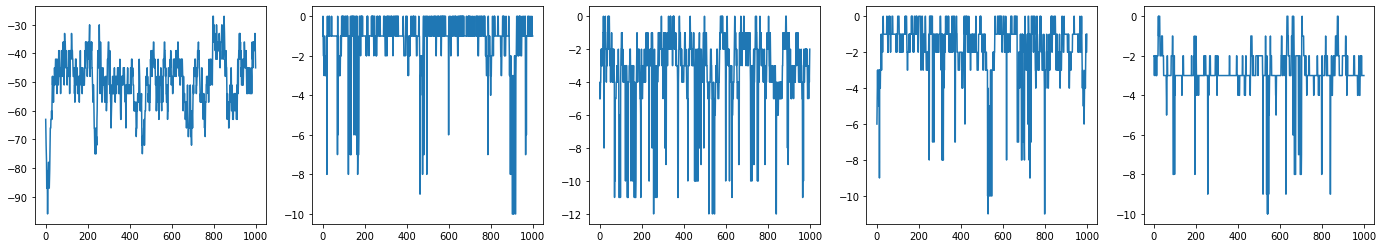

| Reward: [ -480. -1155. -3196. -2112. -2331.] | Episode: 38 | actor loss: -0.039743253774940965 |critic loss: 0.830853545665741 | reward loss: 197.840615773201 | done: False


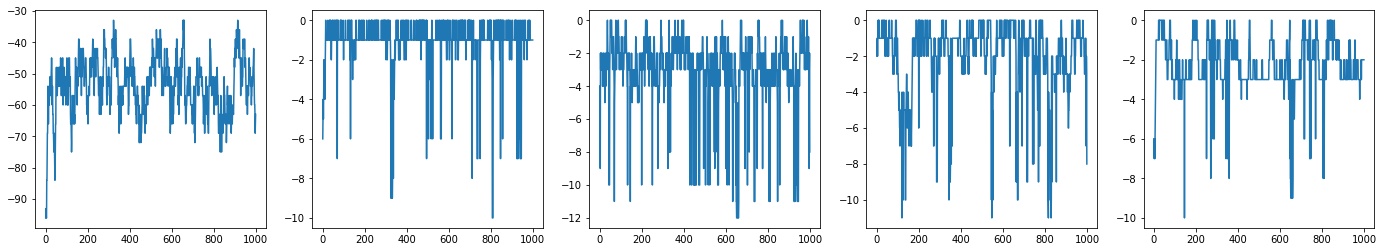

| Reward: [ -504. -1312. -3220. -2023. -2556.] | Episode: 39 | actor loss: -0.1545805186033249 |critic loss: 0.9581462502479553 | reward loss: 159.76269192695617 | done: False


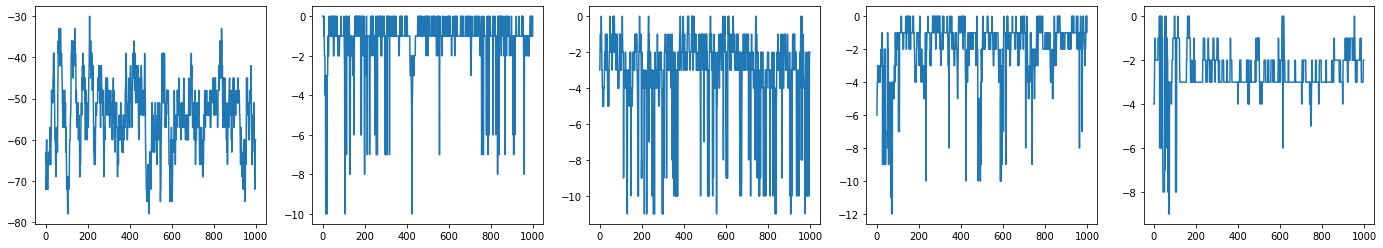

| Reward: [ -524. -1367. -3392. -1932. -2402.] | Episode: 40 | actor loss: -0.010948217869736255 |critic loss: 0.9416007757186889 | reward loss: 144.0526558637619 | done: False


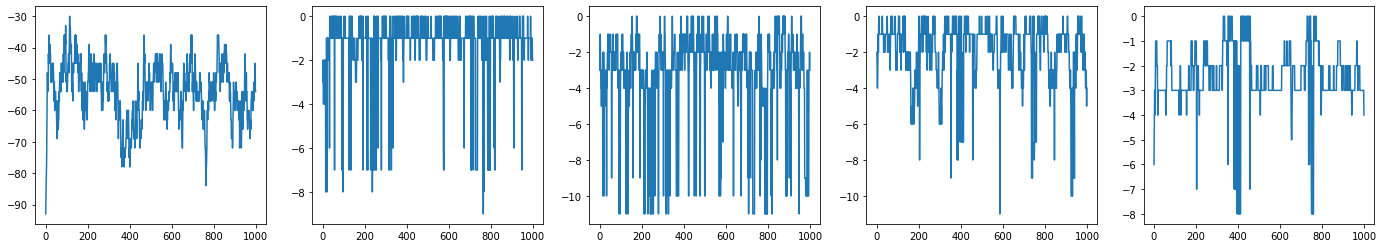

| Reward: [ -516. -1405. -3680. -2415. -2510.] | Episode: 41 | actor loss: 0.06262325383722782 |critic loss: 0.9481050848960877 | reward loss: 151.58828363418579 | done: False


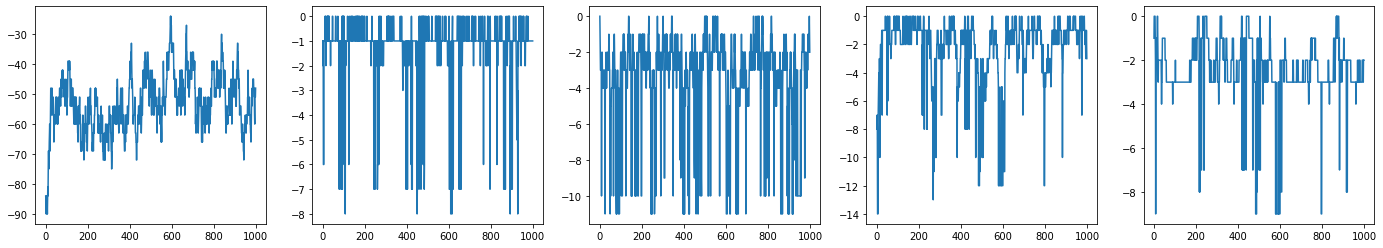

| Reward: [ -492. -1336. -3225. -3304. -2487.] | Episode: 42 | actor loss: 0.021785201865350247 |critic loss: 0.9036059021949768 | reward loss: 134.7473864555359 | done: False


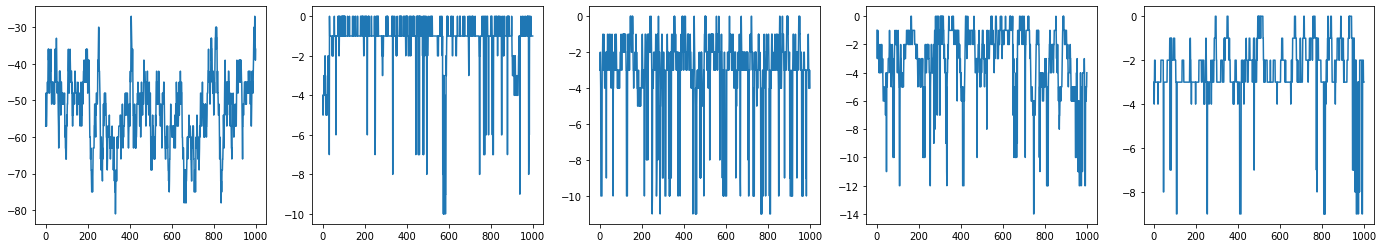

| Reward: [ -581. -1463. -3274. -2409. -2745.] | Episode: 43 | actor loss: -0.08489044159650802 |critic loss: 0.9454000353813171 | reward loss: 127.33147912025451 | done: False


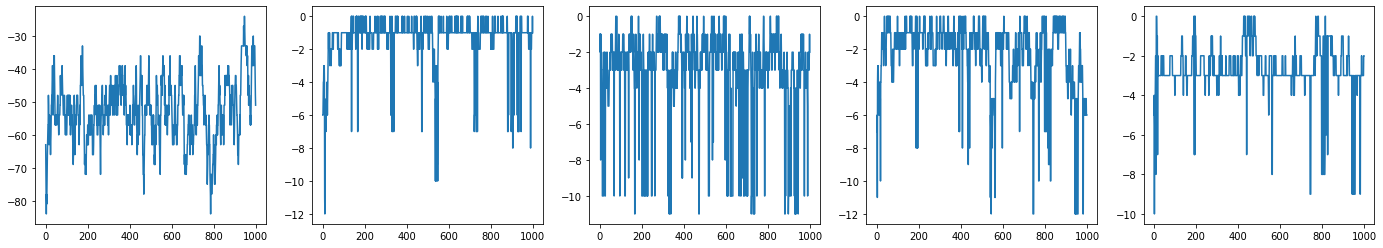

| Reward: [ -315. -1607. -3295. -2466. -2745.] | Episode: 44 | actor loss: -0.04784546718001366 |critic loss: 0.9180708050727844 | reward loss: 123.05854818820953 | done: False


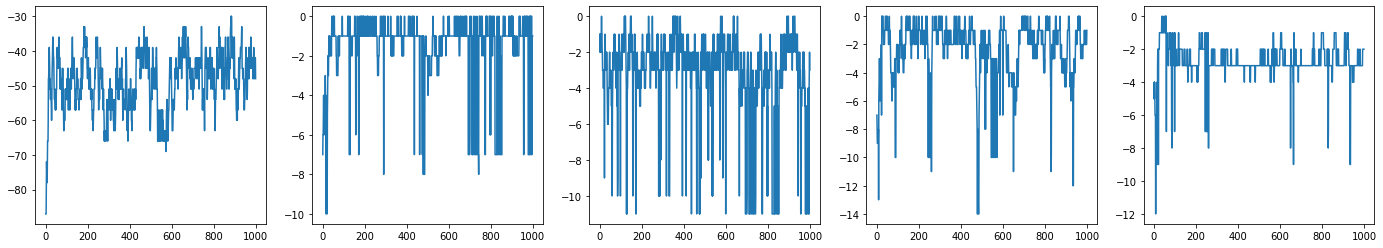

| Reward: [ -294. -1265. -3077. -2488. -2666.] | Episode: 45 | actor loss: -0.0728571057319641 |critic loss: 0.9364749908447265 | reward loss: 119.49132134914399 | done: False


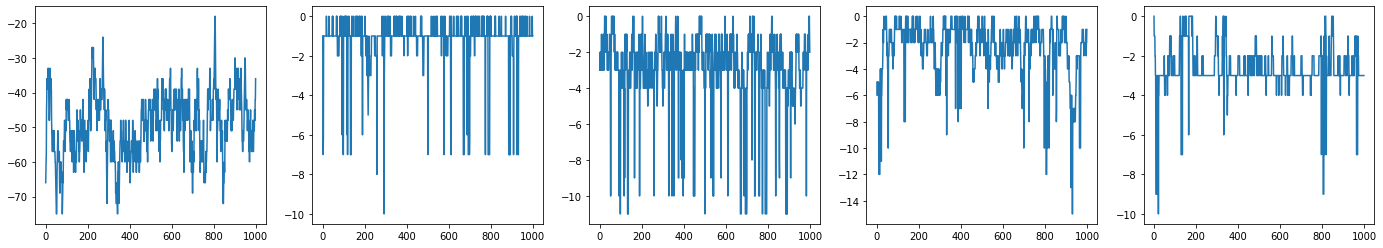

| Reward: [ -249. -1183. -3056. -3727. -2971.] | Episode: 46 | actor loss: -0.040497307851910594 |critic loss: 1.0072205424308778 | reward loss: 111.35838468074799 | done: False


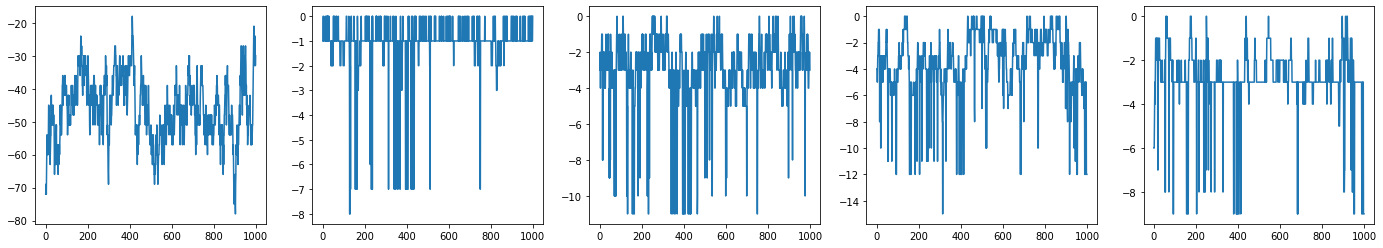

| Reward: [ -273. -1438. -3450. -3342. -2661.] | Episode: 47 | actor loss: -0.06381538473069667 |critic loss: 0.8742132902145385 | reward loss: 109.56087536811829 | done: False


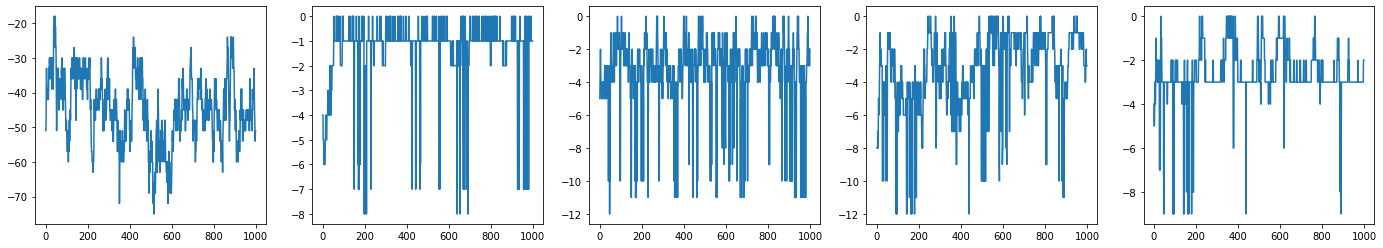

| Reward: [ -128. -1156. -3122. -2436. -2791.] | Episode: 48 | actor loss: -0.10103002041578293 |critic loss: 0.8686160922050477 | reward loss: 102.836390376091 | done: False


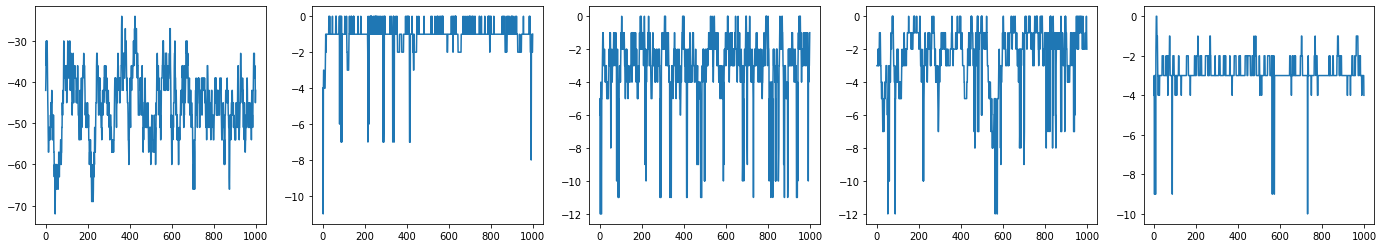

| Reward: [ -328. -1331. -3253. -3062. -2757.] | Episode: 49 | actor loss: -0.05527540072798729 |critic loss: 0.9240195989608765 | reward loss: 104.53269579410554 | done: False


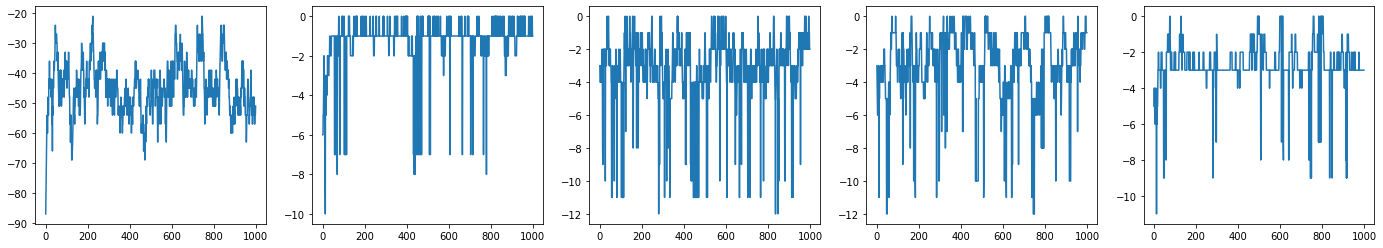

| Reward: [ -168. -1369. -3226. -3182. -2638.] | Episode: 50 | actor loss: -0.14081746339797974 |critic loss: 0.9638617157936096 | reward loss: 92.2863875389099 | done: False


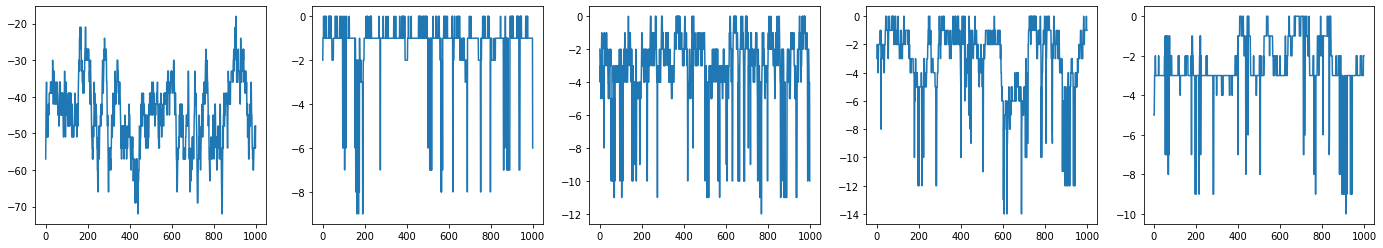

| Reward: [ -160. -1505. -3128. -2336. -2983.] | Episode: 51 | actor loss: -0.09186899140477181 |critic loss: 1.0005910396575928 | reward loss: 78.3846143245697 | done: False


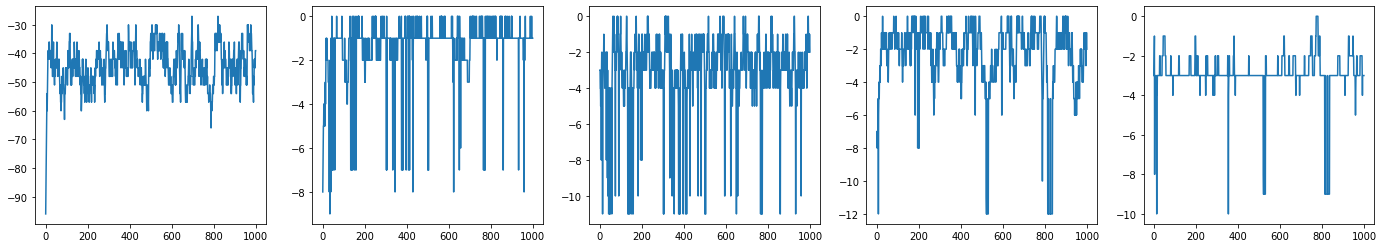

| Reward: [ -191. -1585. -3578. -3153. -2987.] | Episode: 52 | actor loss: -0.07504123635590076 |critic loss: 0.979481863975525 | reward loss: 75.90092520713806 | done: False


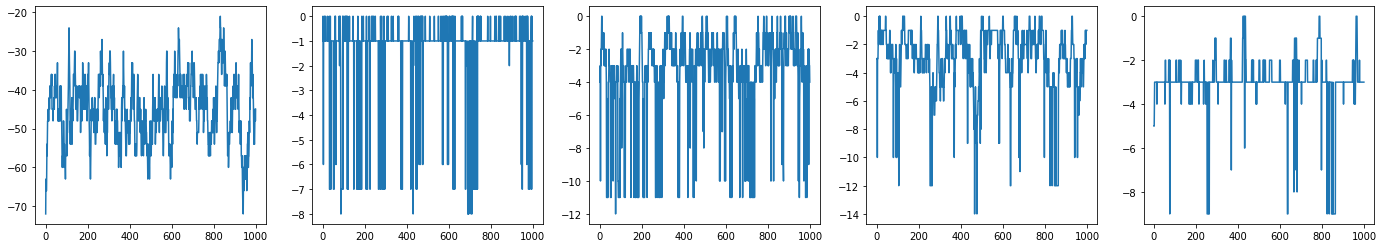

| Reward: [ -210. -1552. -3030. -2950. -3210.] | Episode: 53 | actor loss: -0.021654207014944405 |critic loss: 0.99270601272583 | reward loss: 55.14360408782959 | done: False


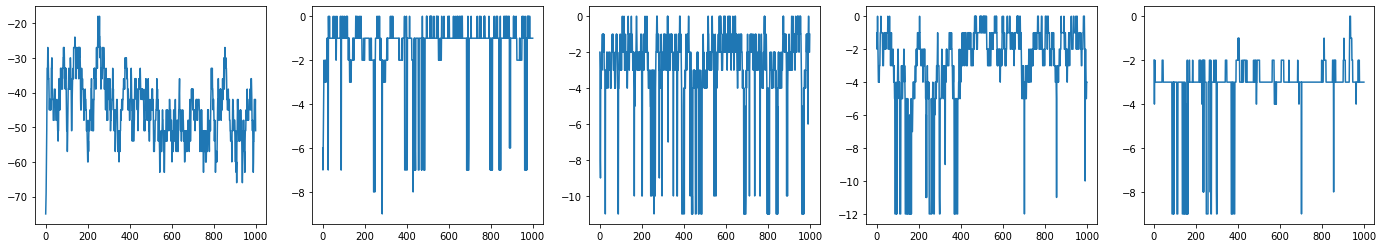

| Reward: [ -186. -2024. -3364. -2289. -2964.] | Episode: 54 | actor loss: 0.019579744897782803 |critic loss: 0.865687119960785 | reward loss: 61.68250951766968 | done: False


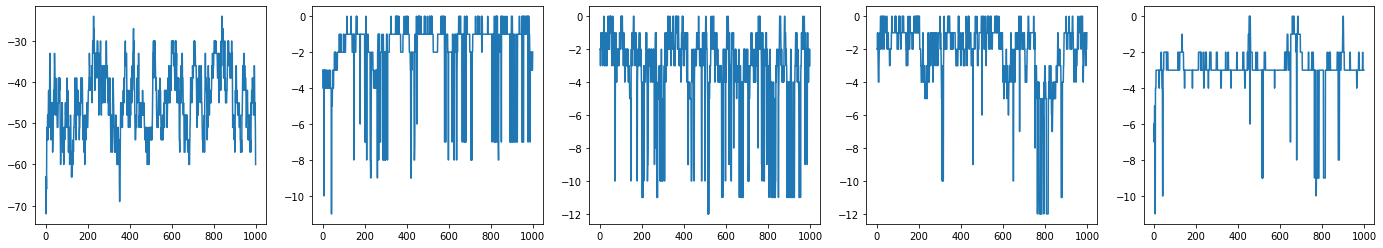

| Reward: [ -208. -1539. -3003. -2820. -3045.] | Episode: 55 | actor loss: -0.015505937999114395 |critic loss: 0.9533842325210571 | reward loss: 60.250732588768 | done: False


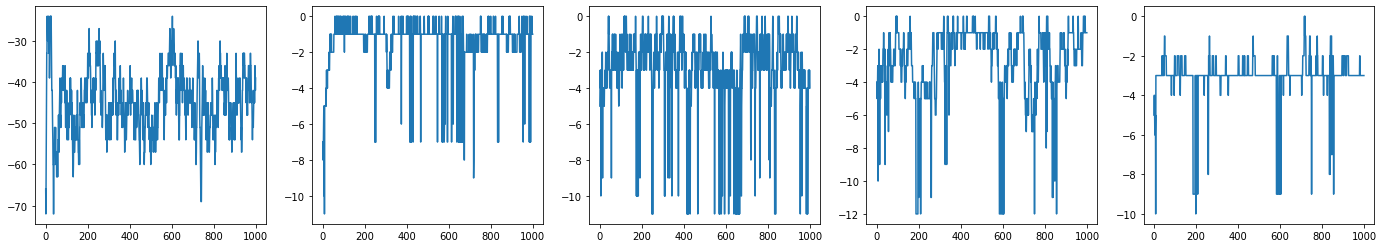

| Reward: [ -210. -1489. -3123. -2576. -2906.] | Episode: 56 | actor loss: -0.07825284749269486 |critic loss: 0.9538295269012451 | reward loss: 52.78661503791809 | done: False


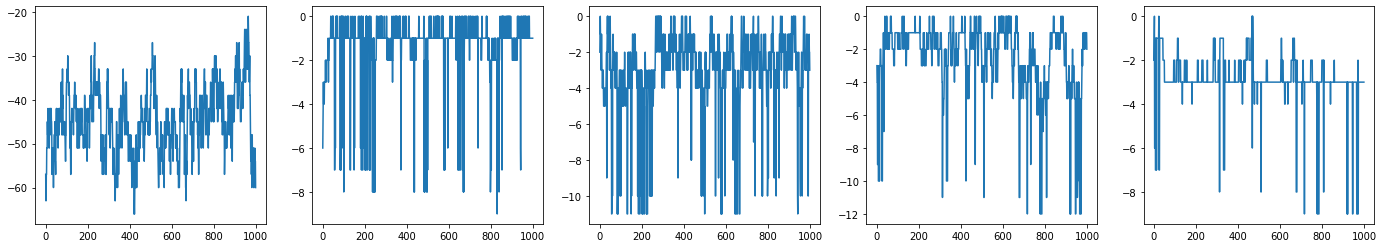

| Reward: [ -213. -1483. -2800. -2171. -2902.] | Episode: 57 | actor loss: -0.00654288362711668 |critic loss: 0.8760756731033326 | reward loss: 65.07070779800415 | done: False


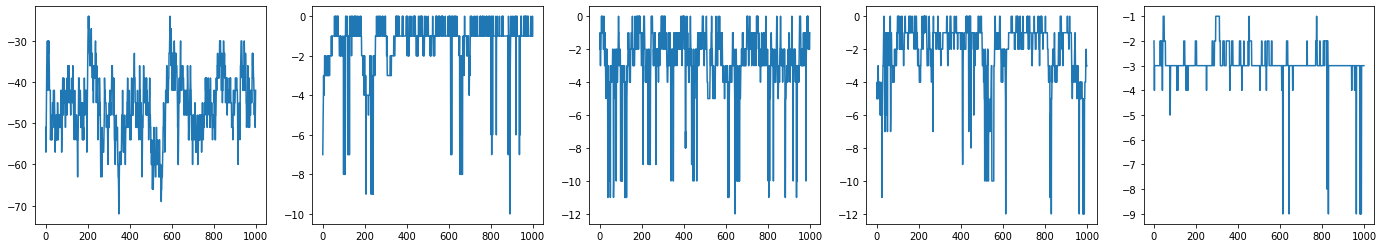

| Reward: [ -103. -1132. -2988. -2119. -2900.] | Episode: 58 | actor loss: -0.133379727602005 |critic loss: 0.8777985811233521 | reward loss: 56.36130352020264 | done: False


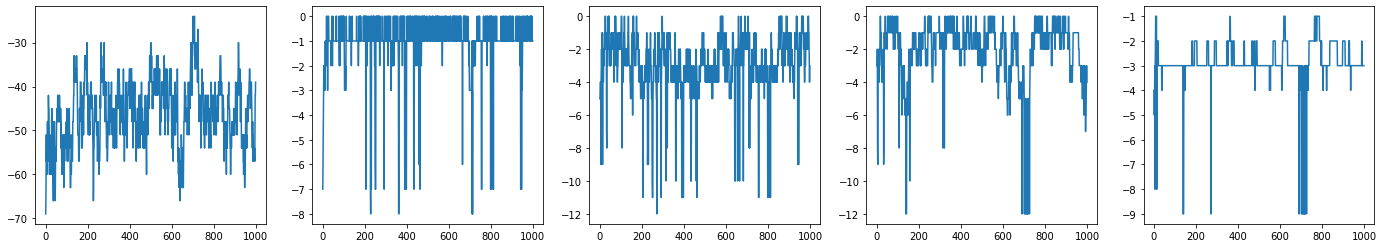

| Reward: [ -167. -1701. -3245. -2048. -2933.] | Episode: 59 | actor loss: 0.06040468495339155 |critic loss: 0.9127015471458435 | reward loss: 53.207933402061464 | done: False


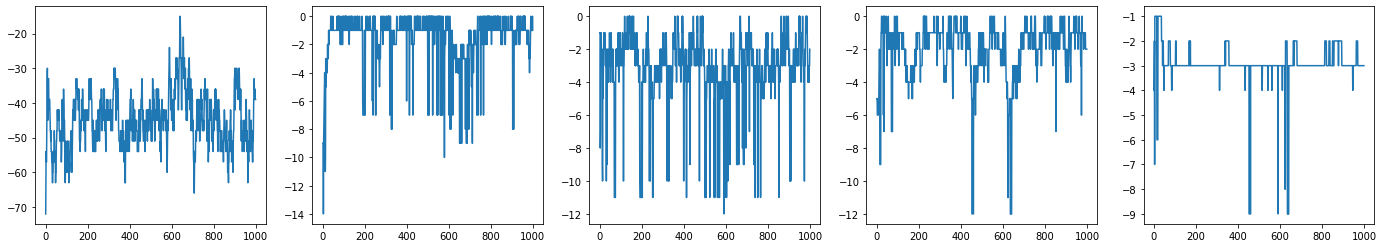

| Reward: [  -86. -1241. -2900. -2006. -2843.] | Episode: 60 | actor loss: -0.09577176421880722 |critic loss: 0.9135703086853028 | reward loss: 59.3437153339386 | done: False


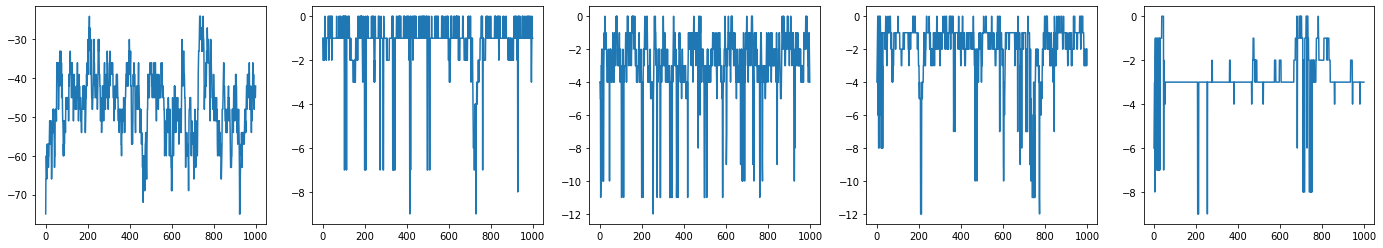

| Reward: [ -160. -1343. -3207. -2205. -2966.] | Episode: 61 | actor loss: -0.07360487878322601 |critic loss: 0.9453378319740295 | reward loss: 57.30994894504547 | done: False


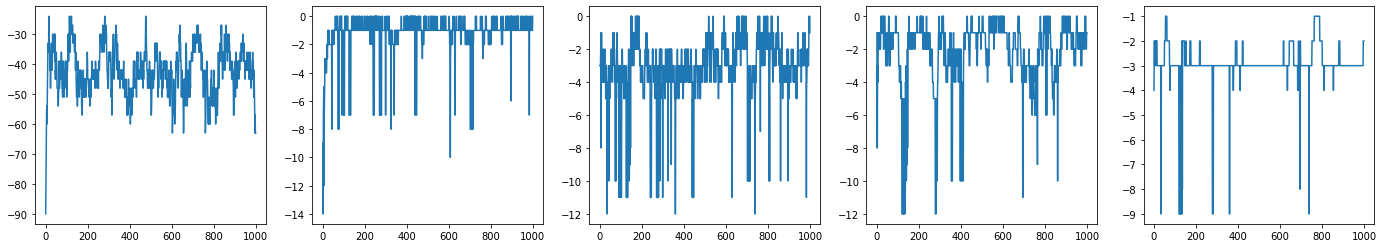

| Reward: [  -61. -1299. -3087. -1470. -2919.] | Episode: 62 | actor loss: -0.012018166901543736 |critic loss: 0.8824588298797608 | reward loss: 52.02482399940491 | done: False


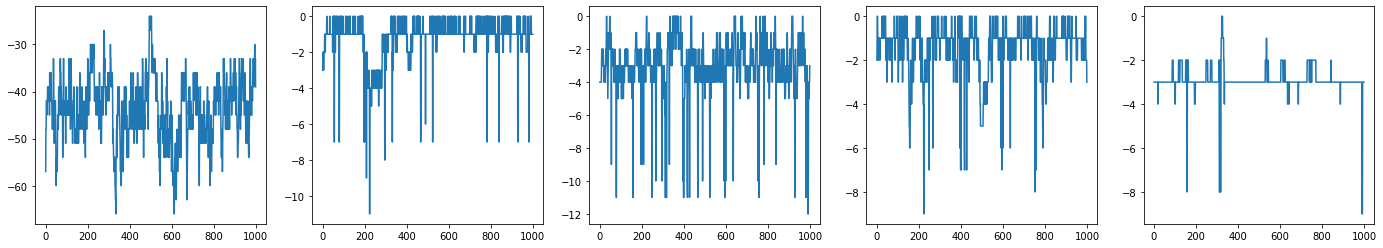

| Reward: [ -185. -1226. -3343. -1652. -2617.] | Episode: 63 | actor loss: -0.17648062258958816 |critic loss: 0.9775595664978027 | reward loss: 60.33793758153915 | done: False


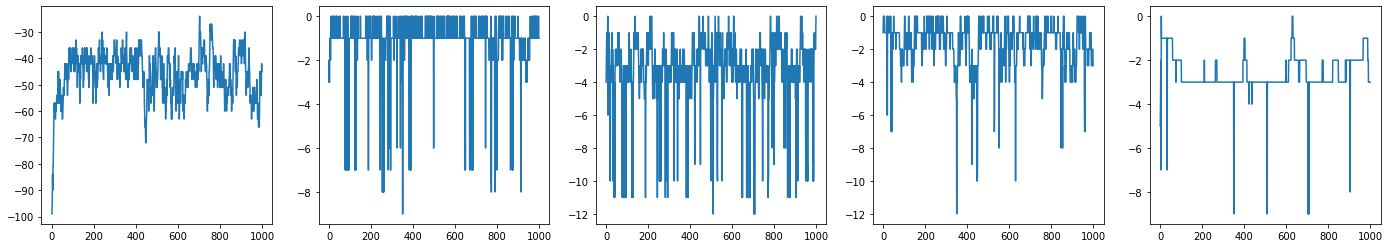

| Reward: [  -68. -1261. -2901. -1870. -2964.] | Episode: 64 | actor loss: -0.068416403606534 |critic loss: 0.900412666797638 | reward loss: 42.5561145067215 | done: False


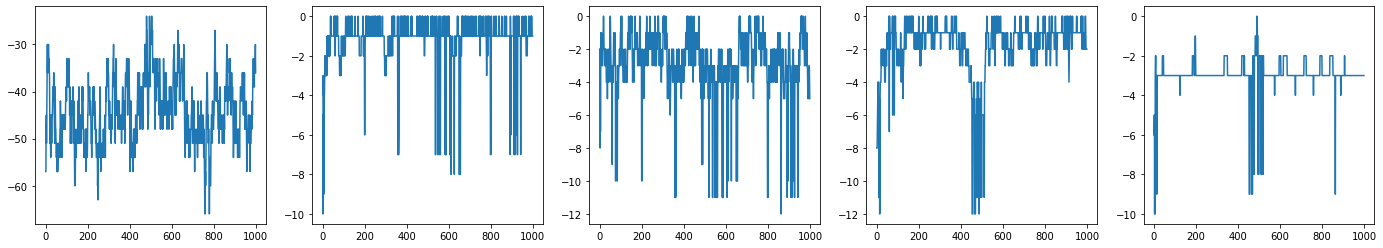

| Reward: [ -270. -1358. -3068. -2419. -2994.] | Episode: 65 | actor loss: 0.01830157279036939 |critic loss: 0.9382947683334351 | reward loss: 53.332525205612185 | done: False


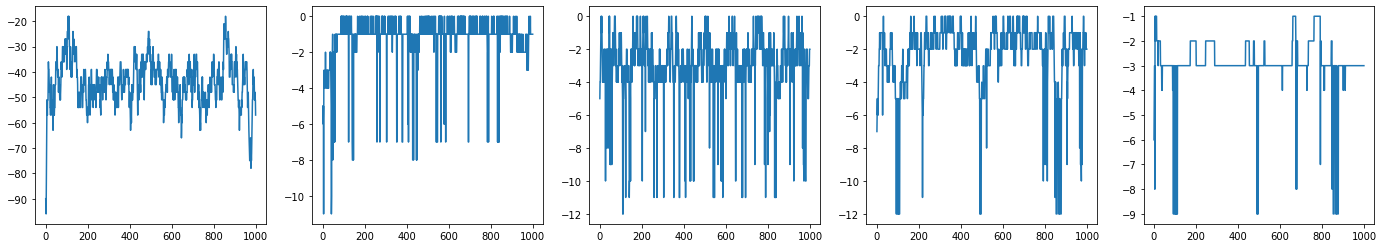

| Reward: [ -102. -1226. -2993. -1653. -2876.] | Episode: 66 | actor loss: -0.0613394945859909 |critic loss: 0.9840013146400451 | reward loss: 41.21440107226372 | done: False


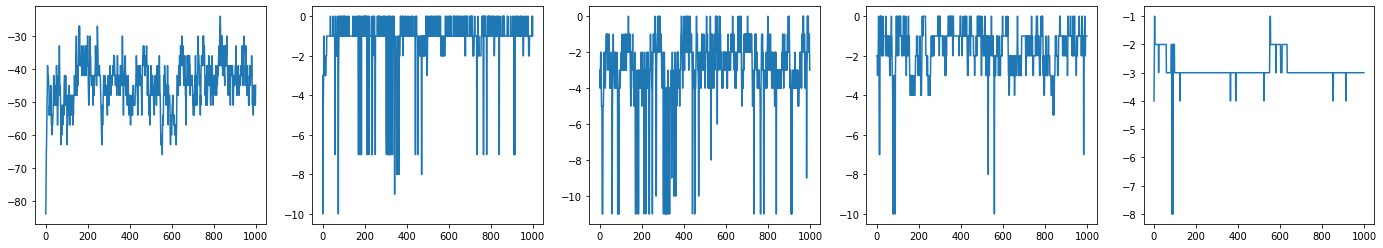

| Reward: [ -169. -1175. -2781. -2008. -2791.] | Episode: 67 | actor loss: 0.03133728802204132 |critic loss: 0.9930851221084595 | reward loss: 43.123727238178255 | done: False


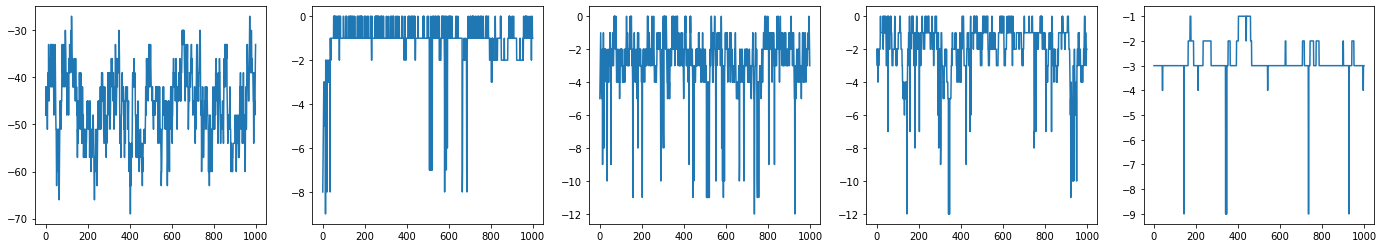

| Reward: [ -117. -1157. -2988. -2025. -2906.] | Episode: 68 | actor loss: -0.0346427608281374 |critic loss: 0.9625386714935302 | reward loss: 40.58598384857178 | done: False


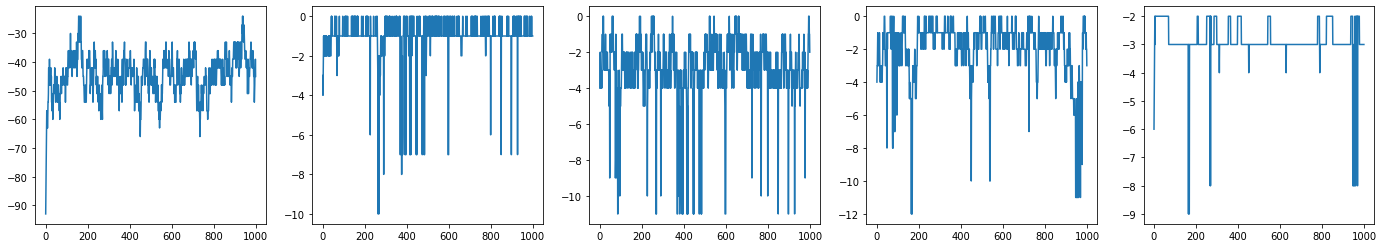

| Reward: [ -159. -1100. -3093. -2227. -2508.] | Episode: 69 | actor loss: -0.009202421363443136 |critic loss: 0.9501786828041077 | reward loss: 51.64801089763641 | done: False


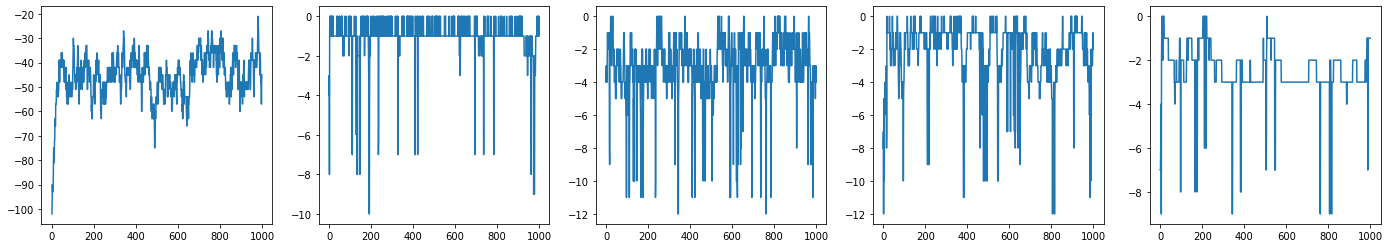

| Reward: [ -204. -1030. -2482. -2155. -2644.] | Episode: 70 | actor loss: -0.03447266267612577 |critic loss: 0.9333743572235107 | reward loss: 45.559871232509614 | done: False


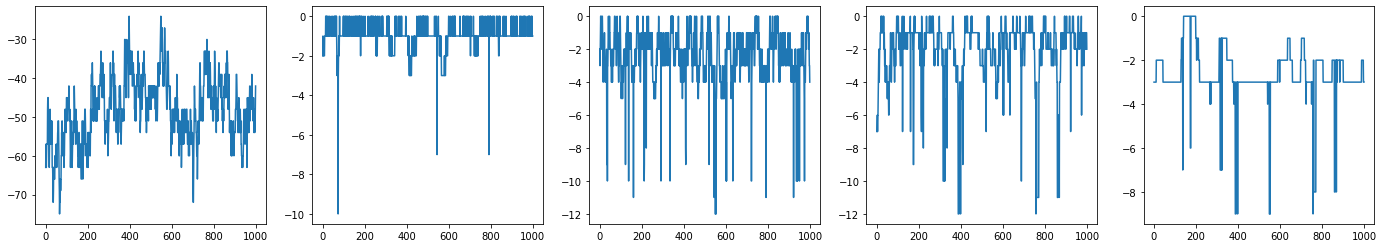

| Reward: [ -114. -1138. -2867. -2187. -2805.] | Episode: 71 | actor loss: -0.06769431494176388 |critic loss: 0.977291464805603 | reward loss: 37.338367557525636 | done: False


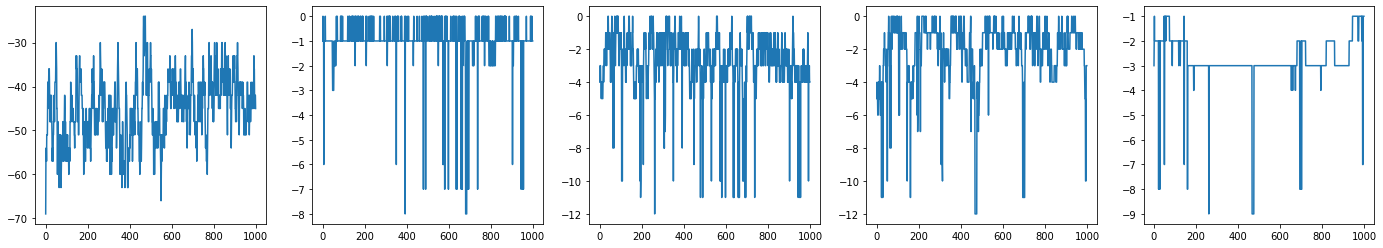

| Reward: [ -152. -1445. -2909. -2424. -2403.] | Episode: 72 | actor loss: -0.005210908682784066 |critic loss: 0.889313805103302 | reward loss: 40.04969787597656 | done: False


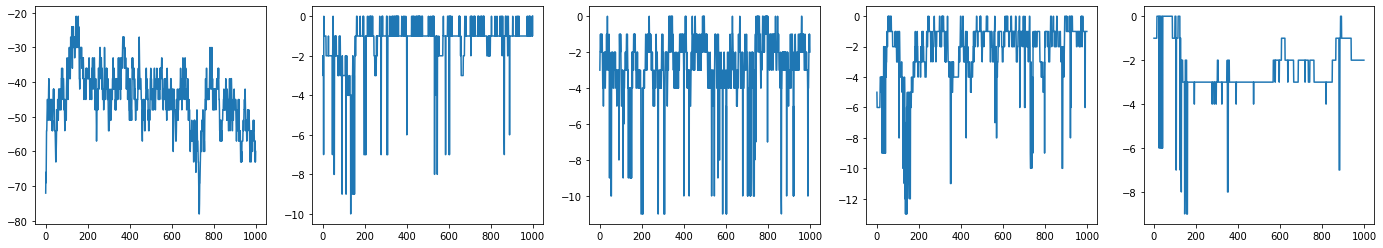

| Reward: [ -200. -1256. -2653. -2826. -3205.] | Episode: 73 | actor loss: -0.05597110502421856 |critic loss: 0.9582718133926391 | reward loss: 43.86801435947418 | done: False


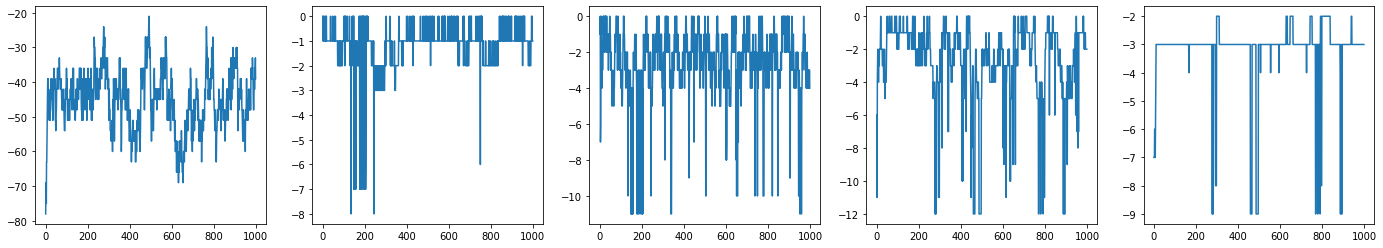

| Reward: [ -144. -1274. -2772. -2353. -2984.] | Episode: 74 | actor loss: -0.1127268873155117 |critic loss: 0.9655917763710022 | reward loss: 34.84166860580444 | done: False


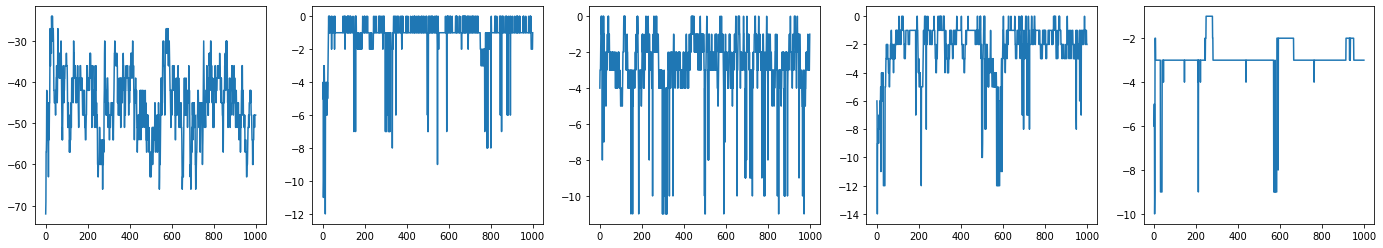

| Reward: [ -182. -1276. -2517. -2138. -2470.] | Episode: 75 | actor loss: 0.0061719177290797235 |critic loss: 0.849551522731781 | reward loss: 34.054249095916745 | done: False


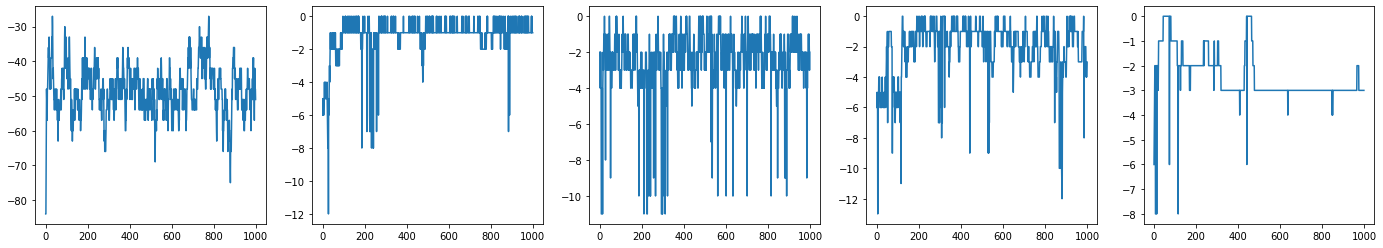

| Reward: [ -154. -1003. -2606. -1737. -2371.] | Episode: 76 | actor loss: -0.10634359642863274 |critic loss: 0.9287757754325867 | reward loss: 40.509820556640626 | done: False


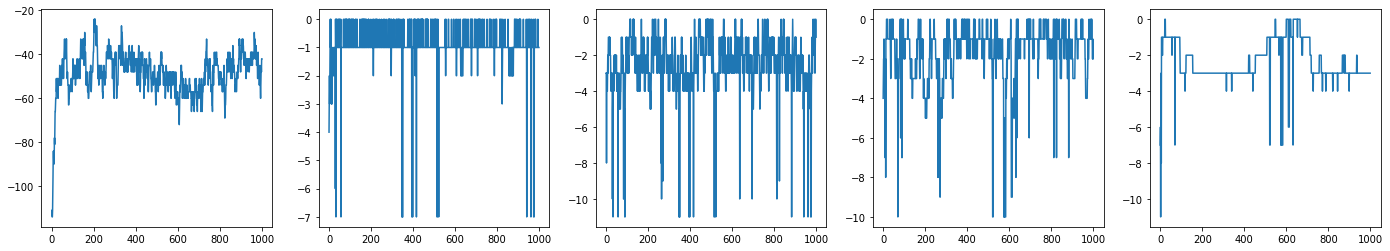

| Reward: [ -134. -1170. -2668. -1945. -2677.] | Episode: 77 | actor loss: 0.008797824010252952 |critic loss: 0.8895944237709046 | reward loss: 37.834441447257994 | done: False


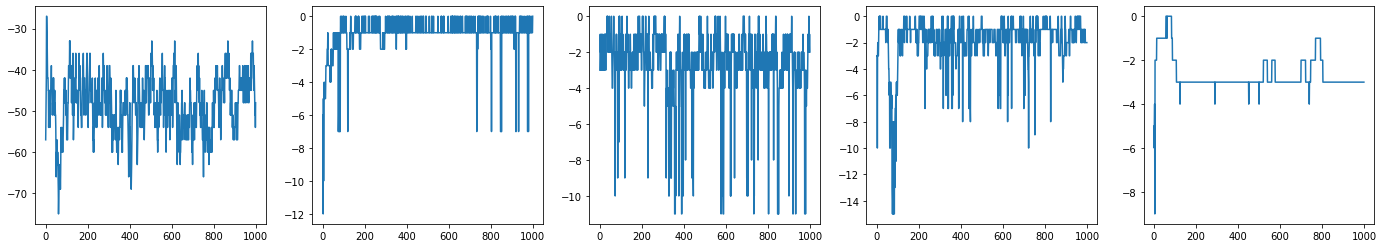

AttributeError: ignored

In [ ]:
import os
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

args = {
    'state_dim' : 5,
    'action_dim' : 5,
    'actor_lr': 0.0001,
    'batch_size' : 200,
    'actor_l1' : 10,
    'actor_l2' : 5,
    'critic_lr':0.001,
    'gamma':0.95,
    'critic_l1':10,
    'critic_l2':5,
    'egr_lr':0.01,
    'egr_l1':10,
    'egr_l2':5,
    'max_episodes':100,
    'summary_dir':'./Power-Converters/marl/results',
    'max_episode_len':1000,
    'scaling':True,
    'buffer_size':1000000,
    'random_seed':1234,
    'mini_batch_size':500,
    'use_gpu':True,
    'save_model':True,
    'load_model':False
}
tf.config.run_functions_eagerly(True)

reward_result = np.zeros(2500)
paths, reward_result = train_multi_agent(env, args, actors, critics, reward_result)
savemat(os.path.join(args['summary_dir'], 'marl.mat'), dict(data=paths, reward=reward_result))

#args

In [ ]:
if args['save_model']:
    for node in range(env.n_agents):
        actors[node].save_weights(
        filepath = args['summary_dir'] + "/actor_"+ str(node) + "_weights.h5",
        overwrite=True,
        save_format='h5')
        print('Saving actor {} weights'.format(node+1))

        critics[node].save_weights(
            filepath = args['summary_dir'] + "/critic_"+ str(node) + "_weights.h5",
            overwrite=True,
            save_format='h5')
        print('Saving critic {} weights'.format(node+1))

In [ ]:
args = {
    'state_dim' : 5,
    'action_dim' : 5,
    'actor_lr': 0.001,
    'batch_size' : 200,
    'actor_l1' : 100,
    'actor_l2' : 50,
    'critic_lr':0.01,
    'gamma':0.95,
    'critic_l1':100,
    'critic_l2':50,
    'egr_lr':0.1,
    'egr_l1':100,
    'egr_l2':50,
    'max_episodes':500,
    'summary_dir':'./Power-Converters/marl/results',
    'max_episode_len':1000,
    'scaling':True,
    'buffer_size':1000000,
    'random_seed':1234,
    'mini_batch_size':500,
    'use_gpu':True
}

# if args['use_gpu']:
#         physical_devices = tf.config.list_physical_devices('GPU') 
#         tf.config.experimental.set_memory_growth(physical_devices[0], True)
env = Grid_World(6,6,5)
replay_buffer1 = ReplayBuffer(int(args['buffer_size']), int(args['random_seed']))
replay_buffer2 = ReplayBuffer(int(args['buffer_size']), int(args['random_seed']))
replay_buffer3 = ReplayBuffer(int(args['buffer_size']), int(args['random_seed']))
replay_buffer4 = ReplayBuffer(int(args['buffer_size']), int(args['random_seed']))
replay_buffer5 = ReplayBuffer(int(args['buffer_size']), int(args['random_seed']))

replay_buffers = [replay_buffer1, replay_buffer2, replay_buffer3, replay_buffer4, replay_buffer5]

In [ ]:
reward_result = np.zeros(2500)
tf.config.run_functions_eagerly(True)

paths, reward_result = train_multi_agent(env, args, actors, critics, reward_result, replay_buffers)

In [ ]:
args.gamma

In [ ]:
def discount_reward(rewards, GAMMA=1):
    reward_sum = 0
    discounted_rewards = []
    for reward in rewards[::-1]:  # reverse buffer r
        reward_sum = reward + GAMMA * reward_sum
        discounted_rewards.append(reward_sum)
    discounted_rewards.reverse()
    discounted_rewards = np.array(discounted_rewards)
    return discounted_rewards

In [ ]:
rewards = np.arange(10)

In [ ]:
rewards.mean()

In [ ]:
discount_reward(rewards)

In [ ]:
s = np.array([20, 10,1,3,2])

In [ ]:
def get_action(actor_model, state, eps=0.04):
    p = actor_model.predict(state.reshape((1,-1)))#.numpy()
    n_actions = np.shape(p)[1]
    return np.random.choice(n_actions, p = p[0])
get_action(actor_model=actor_1, state = s)

In [ ]:
[0.95** (i+1) for i in range(10)][::-1]

In [ ]:
np.random.choice(5)

In [ ]:
np.random.choice([1,2], p = [0.1,0.9])

In [ ]:
class Actor(tf.keras.Model):
    """
    creates a two layer nn with a soft max output layer for actor.
    we use 'categorical_crossentropy' as the loss function and Adam optimzer
    Arguments:
    num_actions - (int) 
    lr - (float)
    """
    def __init__(self, num_actions = 5):
        super(Actor, self).__init__()
        self.dense_1 = keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal())
        self.dense_2 = keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal())
        self.output_layer = keras.layers.Dense(num_actions, activation='softmax')

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        return self.output_layer(x)




class Critic(tf.keras.Model):
    """
    creates a two layer nn with a soft max output layer for critic.
    """
    def __init__(self):
        super(Critic, self).__init__()
        self.dense_1 = keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal())
        self.dense_2 = keras.layers.Dense(30, activation='relu', kernel_initializer=keras.initializers.he_normal())
        self.output_layer = keras.layers.Dense(1)
        #self.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam())


    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        return self.output_layer(x)

In [ ]:
critics[0].summary()
actors[0].summary()

In [ ]:
critics = [Critic() for _ in range(env.n_agents)]

huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
for critic in critics:
    critic.compile(loss = huber_loss, optimizer = keras.optimizers.Adam(learning_rate=args['critic_lr']))

actors = [Actor(num_actions = env.n_actions) for _ in range(env.n_agents)]
for actor in actors:
    actor.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=args['actor_lr']))

critics[0].summary()
actors[0].summary()

In [ ]:
import numpy as np

In [ ]:
x= np.array([1,1,1,1,1])
x= np.array([1,1,1,1,1])
for a, b in zip(x,x):
    print(a,a)